# HIERARCHICAL GATING: Two-Stage Sequential Gating Pipeline

This notebook implements a two-stage hierarchical gating strategy:

**Stage 1:** Gate entire population on `avg_speed_um_s` vs `self_intersections` (scaled)
- Creates 4 gates in population-relative space
- Adds columns: `gate_id`, `gate_name`

**Stage 2:** Hierarchically gate a subset on `anomalous_exponent` vs `cum_displacement_um` (unscaled)
- Only evaluates rows from Gate 1's `low_speed_low_intersections` population|
- Adds columns: `gate2_id`, `gate2_name`

**Final:** Manual classifier combining gate1_name + gate2_name → overall population names


## 🎨 Setup: Colors & Imports


In [1]:
# Raiders color palette
raiders = ['#140f19', '#ebe1ce', '#ed1e24', '#fbd10c', '#6cc176', '#95d6d7']
raiders_text = ['#140f19', '#ebe1ce']
raiders_colors = ['#ed1e24', '#fbd10c', '#6cc176', '#95d6d7']
raiders_colors2 = ['#ed1e24', '#DE8F05', '#6cc176', '#95d6d7']

colorblind_colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161', 
                     '#FBAFE4', '#949494', '#ECE133', '#56B4E9', '#D55E00']

gate_fill_colors = ['#949494', '#ECE133', '#56B4E9', '#D55E00']


In [2]:
from __future__ import division, unicode_literals, print_function
import sys
sys.path.append('../src')

import SPTnano as spt

master = spt.config.MASTER
saved_data = spt.config.SAVED_DATA

pixelsize_microns = spt.config.PIXELSIZE_MICRONS
time_between_frames = spt.config.TIME_BETWEEN_FRAMES
orderofconditions = spt.config.ORDEROFCONDITIONS
features = spt.config.FEATURES
min_track_length = spt.config.TIME_WINDOW

from IPython.display import Markdown, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import pims
import trackpy as tp
import os
import glob
import nd2
import seaborn as sns

%matplotlib inline

mpl.rc('figure', figsize=(10, 5))
mpl.rc('image', cmap='gray')
sns.set_context("notebook", rc={"xtick.labelsize": 10, "ytick.labelsize": 10})


Config module loaded. Master directory is: D:/TRANSFORMER_DEVELOPMENT/


## Load Data


In [3]:
import polars as pl

driveletter = 'F:'

# Configure your paths
MASTER_DIR = driveletter + "/Analyzed/"
SAVE_DIR = driveletter + "/Analyzed/FIXED_WINDOW_UIDS_20251030_155925"

instant_df = pl.read_parquet(os.path.join(SAVE_DIR, 'master_instant_df_FIXED.parquet'))
windowed_df = pl.read_parquet(os.path.join(SAVE_DIR, 'master_windowed_df_FIXED.parquet'))

# Update drive letter if needed
instant_df = instant_df.with_columns(
    pl.col('foldername').str.replace('Z:', driveletter)
)
windowed_df = windowed_df.with_columns(
    pl.col('foldername').str.replace('Z:', driveletter)
)

print(f"Updated drive letter from Z: to {driveletter} in foldername columns")

# Remove bad fits
print("Before removing bad fits:")
print(f"windowed_df shape: {windowed_df.shape}")

windowed_df = windowed_df.filter(pl.col('bad_fit_flag') == False)

unique_window_uids = windowed_df.select(pl.col('window_uid')).unique()
print(f"Number of unique window_uids: {unique_window_uids.shape[0]}")

instant_df = instant_df.filter(pl.col('window_uid').is_in(unique_window_uids['window_uid']))

print(f"\n✅ Data loaded:")
print(f"   Windowed: {windowed_df.shape}")
print(f"   Instant: {instant_df.shape}")


Updated drive letter from Z: to F: in foldername columns
Before removing bad fits:
windowed_df shape: (1229323, 63)
Number of unique window_uids: 913243


C:\Users\User\AppData\Local\Temp\ipykernel_19712\1107473175.py:31: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  instant_df = instant_df.filter(pl.col('window_uid').is_in(unique_window_uids['window_uid']))



✅ Data loaded:
   Windowed: (913243, 63)
   Instant: (34985340, 46)


### (Optional) Gallery view of curated tracks for Gate 1

**Note:** This section is for visualizing a small curated subset of tracks to understand behaviors before gating.
Skip if you want to go straight to gating the full population.


In [4]:
# Optional: Create curated subset with behavior labels for visualization
# Skip this if you don't have pre-labeled tracks

# Example structure (customize with your window_UIDs):
chosen_window_UIDs = {
    "transport": ['eekrw_131_7338_R1_1_2849.0_2908.0', 
'eekrw_132_7896_R1_10_301.0_360.0', 'eekrw_132_7896_R1_11_331.0_390.0', 'eekrw_132_7896_R1_9_271.0_330.0',
 'eekrw_72_27796_R1_4_2092.0_2151.0', 'eekrw_72_27796_R1_5_2122.0_2181.0',
'eekrw_64_26280_R1_0_2401.0_2461.0',
'eekrw_119_3224_R1_5_151.0_210.0', 'eekrw_119_3224_R1_6_181.0_240.0',
'eekrw_122_4897_R1_0_3896.0_3955.0', 'eekrw_122_4897_R1_1_3926.0_3985.0', 'eekrw_122_4897_R1_2_3956.0_4015.0',
'eekrw_124_5697_R1_0_822.0_882.0', 'eekrw_124_5697_R1_1_853.0_912.0',
# 'eekrw_124_5718_R1_0_1196.0_1255.0',
 'eekrw_124_5718_R1_1_1226.0_1285.0',
'eekrw_64_26137_R1_0_3723.0_3784.0',
#  'eekrw_64_26137_R1_1_3755.0_3814.0', 
# 'eekrw_64_26137_R1_2_3785.0_3844.0',
'eekrw_124_5697_R1_0_822.0_882.0', 'eekrw_124_5697_R1_1_853.0_912.0',
'eekrw_63_26099_R1_0_2180.0_2239.0', 
'eekrw_123_5096_R1_0_1923.0_1983.0'],
    "bound": ['eemrw_33_3980_R1_10_1876.0_1936.0', 'eemrw_33_3980_R1_8_1816.0_1875.0', 'eemrw_33_3980_R1_9_1846.0_1905.0',
'eekrw_64_26165_R1_0_4231.0_4294.0', 'eekrw_64_26165_R1_1_4263.0_4327.0',
'eemrw_33_3513_R1_16_3418.0_3477.0', 'eemrw_33_3513_R1_17_3448.0_3507.0', 'eemrw_33_3513_R1_18_3478.0_3537.0',
'eemrw_42_5444_R1_23_996.0_1055.0', 'eemrw_42_5444_R1_24_1026.0_1085.0', 'eemrw_42_5444_R1_25_1056.0_1115.0',
'eemrw_34_4506_R1_0_2043.0_2106.0', 'eemrw_34_4506_R1_1_2077.0_2137.0',
'eekrw_77_28613_R1_35_3643.0_3702.0', 'eekrw_77_28613_R1_36_3673.0_3732.0', 'eekrw_77_28613_R1_37_3703.0_3762.0',
'eemrw_34_4188_R1_1_5333.0_5392.0',
'eemrw_33_3399_R1_3_2262.0_2322.0',
'eemrw_42_5293_R1_23_691.0_750.0', 'eemrw_42_5293_R1_24_721.0_780.0', 'eemrw_42_5293_R1_25_751.0_810.0',
'eekrw_66_26462_R1_10_3647.0_3706.0', 'eekrw_66_26462_R1_11_3677.0_3736.0', 'eekrw_66_26462_R1_12_3707.0_3766.0',
'eeh2h_eeh2x_22_3800_R2_R2_1_5583.0_5642.0', 'eeh2h_eeh2x_22_3800_R2_R2_2_5613.0_5672.0', 'eeh2h_eeh2x_22_3800_R2_R2_3_5643.0_5702.0'],
    "transient": ['eeh2h_38_12054_R1_0_2432.0_2493.0',
'eekrw_123_5265_R1_1_5141.0_5200.0',
'eekrw_73_28118_R1_0_1708.0_1768.0', 'eekrw_73_28118_R1_1_1739.0_1798.0', 'eekrw_73_28118_R1_2_1769.0_1828.0',
'eeh2h_30_10132_R1_0_2059.0_2118.0',
'eemrw_37_4775_R1_0_2880.0_2950.0', 'eemrw_37_4775_R1_1_2919.0_2983.0',
'eemrw_34_4032_R1_0_2811.0_2872.0',
'eemrw_33_3474_R1_0_2638.0_2699.0',
'eemrw_40_5120_R1_0_3095.0_3155.0',
'eeh2h_eeh2x_31_7315_R2_R2_0_5427.0_5492.0',
'eeh2h_eeh2x_4_10006_R1_R1_0_5714.0_5773.0']}

# Create mapping and filter
uid_to_category = {}
for category, uids in chosen_window_UIDs.items():
    for uid in uids:
        uid_to_category[uid] = category

all_chosen_uids = list(uid_to_category.keys())

filtered_windowed_df = windowed_df.filter(pl.col('window_uid').is_in(all_chosen_uids))
filtered_windowed_df = filtered_windowed_df.with_columns(
    pl.col('window_uid').replace(uid_to_category, default=None).alias('behavior_type')
)

filtered_instant_df = instant_df.filter(pl.col('window_uid').is_in(all_chosen_uids))
filtered_instant_df = filtered_instant_df.with_columns(
    pl.col('window_uid').replace(uid_to_category, default=None).alias('behavior_type')
)

print(f"Filtered to {len(filtered_windowed_df)} curated tracks")
print(filtered_windowed_df.group_by('behavior_type').agg(pl.len().alias('count')))


Filtered to 40 curated tracks
shape: (3, 2)
┌───────────────┬───────┐
│ behavior_type ┆ count │
│ ---           ┆ ---   │
│ str           ┆ u32   │
╞═══════════════╪═══════╡
│ transient     ┆ 11    │
│ transport     ┆ 14    │
│ bound         ┆ 15    │
└───────────────┴───────┘


C:\Users\User\AppData\Local\Temp\ipykernel_19712\3417226521.py:53: DeprecationWarning: the `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
(Deprecated in version 1.0.0)
  pl.col('window_uid').replace(uid_to_category, default=None).alias('behavior_type')
C:\Users\User\AppData\Local\Temp\ipykernel_19712\3417226521.py:58: DeprecationWarning: the `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
(Deprecated in version 1.0.0)
  pl.col('window_uid').replace(uid_to_category, default=None).alias('behavior_type')


Gallery categories in order: ['transport', 'bound', 'transient']
Collected 27 tracks total
Using calculated subplot size: 3.50 μm
Grid layout: 5 rows × 6 columns


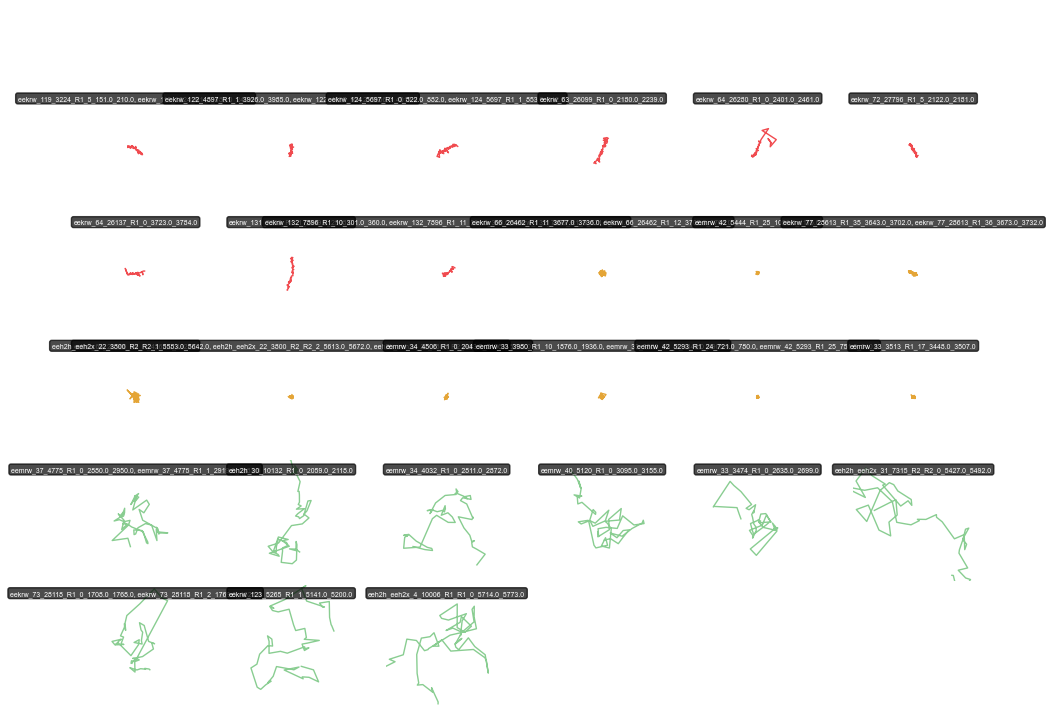

Gallery created with 27 tracks


In [5]:
# Gallery visualization of curated tracks (if using filtered subset)
saved_dir = 'F:/plots/finals/'

# Uncomment and run if you have a curated subset:
gallery_result = spt.gallery_of_tracks_v4(
    filtered_instant_df,
    color_by="behavior_type",
    num_tracks=25,
    order=['transport', 'bound', 'transient'],
    custom_colors=raiders_colors2,
    track_length_frames=60,
    spacing_factor=1.0,
    line_width=1.0,
    figsize=(12, 8),
    text_size=5,
    show_annotations=True,
    annotation="{window_uid}",
    annotation_color="w",
    transparent_background=True,
    save_path=saved_dir + "gallery_curated_tracks_gate1.svg"
)

print(f"Gallery created with {gallery_result['total_tracks']} tracks")


In [6]:
# Cell 6: Markdown
## STAGE 1: First Gating (Speed vs Intersections)
### Fit scaler on full population

# Cell 7: Python
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

feat_x_gate1 = 'avg_speed_um_s'
feat_y_gate1 = 'self_intersections'

scaler_gate1 = Pipeline([
    ('std', StandardScaler()),
    ('minmax', MinMaxScaler())
])

scaler_gate1.fit(windowed_df[[feat_x_gate1, feat_y_gate1]])

print("="*80)
print("✅ SCALER FITTED ON FULL POPULATION")
print("="*80)
print(f"   Features: {feat_x_gate1}, {feat_y_gate1}")
print(f"   Total tracks: {len(windowed_df):,}")

# Cell 8: Python - Create ROI Manager
roi_manager_gate1 = spt.ROIManager(
    df=windowed_df,
    x_col=feat_x_gate1,
    y_col=feat_y_gate1,
    scaler=scaler_gate1
)

print(f"✅ Gate 1 ROIManager created for {len(windowed_df):,} tracks")

# Cell 9: Python - Define Gates
roi_manager_gate1.clear_gates()

roi_manager_gate1.add_rectangle_gate(
    x_min=0.0, x_max=0.2, y_min=0.0, y_max=0.14,
    name="low_speed_low_intersections"
)

roi_manager_gate1.add_rectangle_gate(
    x_min=0.2, x_max=1.0, y_min=0.0, y_max=0.14,
    name="high_speed_low_intersections"
)

roi_manager_gate1.add_rectangle_gate(
    x_min=0.0, x_max=0.3, y_min=0.14, y_max=1.0,
    name="low_speed_high_intersections"
)

roi_manager_gate1.add_rectangle_gate(
    x_min=0.3, x_max=1.0, y_min=0.14, y_max=1.0,
    name="high_speed_high_intersections"
)

print("✅ Gate 1 gates defined")

# Cell 10: Python - Apply Gate 1
windowed_df_classified = roi_manager_gate1.classify_data(
    windowed_df,
    x_col=feat_x_gate1,
    y_col=feat_y_gate1
)

summary_gate1 = roi_manager_gate1.get_gate_summary(windowed_df_classified)

print("\n" + "="*80)
print("✅ GATE 1: FULL DATASET CLASSIFIED")
print("="*80)
print(f"Total tracks: {summary_gate1['total_points']:,}")
print(f"\n📊 Gate 1 breakdown:")
for gate in summary_gate1['gates']:
    print(f"   {gate['name']:35s}: {gate['count']:8,} tracks ({gate['percent']:5.1f}%)")

✅ SCALER FITTED ON FULL POPULATION
   Features: avg_speed_um_s, self_intersections
   Total tracks: 913,243
✅ Gate 1 ROIManager created for 913,243 tracks
🗑️  Cleared 0 gate(s)
✅ Added rectangular gate: x=[0.000, 0.200], y=[0.000, 0.140]
   Total gates: 1
✅ Added rectangular gate: x=[0.200, 1.000], y=[0.000, 0.140]
   Total gates: 2
✅ Added rectangular gate: x=[0.000, 0.300], y=[0.140, 1.000]
   Total gates: 3
✅ Added rectangular gate: x=[0.300, 1.000], y=[0.140, 1.000]
   Total gates: 4
✅ Gate 1 gates defined


c:\Users\User\miniforge3\envs\nanoSPT\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\User\miniforge3\envs\nanoSPT\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



✅ GATE 1: FULL DATASET CLASSIFIED
Total tracks: 913,243

📊 Gate 1 breakdown:
   low_speed_low_intersections        :  110,349 tracks ( 12.1%)
   high_speed_low_intersections       :  557,990 tracks ( 61.1%)
   low_speed_high_intersections       :  214,035 tracks ( 23.4%)
   high_speed_high_intersections      :   30,863 tracks (  3.4%)


In [7]:
# Cell 11: Markdown
## 🎯 STAGE 2: Hierarchical Gating (Anomalous Exponent vs Displacement)
### Only gate the `low_speed_low_intersections` population

# Cell 12: Python - Setup Gate 2
feat_x_gate2 = 'anomalous_exponent'
feat_y_gate2 = 'cum_displacement_um'

parent_gate_name = 'low_speed_low_intersections'
parent_gate_id = 0

parent_pop = windowed_df_classified.filter(pl.col('gate_id') == parent_gate_id)
print(f"Parent population: {len(parent_pop):,} tracks")
# print(f"Parent gate name(s): {parent_pop['gate_name'].unique()}")

# Cell 13: Python - Create ROI Manager for Gate 2
roi_manager_gate2 = spt.ROIManager(
    df=windowed_df_classified,
    x_col=feat_x_gate2,
    y_col=feat_y_gate2,
    scaler=None  # Unscaled!
)

print("✅ Gate 2 ROIManager created (unscaled mode)")

# Cell 14: Python - Define Gate 2 polygons
coords_high_a_low_d = [
    # (1.1, 0.0), (2.25, 7.0), (3.0, 7.0), (3.0, 0.0),
    (1.1, 0.0), (2.25, 8.0), (3.0, 8.0), (3.0, 0.0),
]
roi_manager_gate2.add_polygon_gate(coords_high_a_low_d, name='high_a_low_displacement')

coords_low_a_high_d = [
    # (0.0, 0.0), (0.0, 7.0), (2.25, 7.0), (1.1, 0.0),
    (-0.5, 0.0), (-0.5, 8.0), (2.25, 8.0), (1.1, 0.0),
]
roi_manager_gate2.add_polygon_gate(coords_low_a_high_d, name='low_a_high_displacement')

print("✅ Gate 2 gates defined")

# Cell 15: Python - Apply Gate 2 HIERARCHICALLY
windowed_df_classified = roi_manager_gate2.classify_data(
    windowed_df_classified,
    x_col=feat_x_gate2,
    y_col=feat_y_gate2,
    gate_col_name='gate2_id',
    gate_name_col='gate2_name',
    parent_gate_col='gate_id',          # ← Hierarchical!
    parent_gate_ids=parent_gate_id,     # ← Only gate parent
    not_applicable_label='not_in_parent_gate'
)

print("\n✅ GATE 2: HIERARCHICAL GATING COMPLETE")
print(windowed_df_classified.group_by('gate2_name').agg(pl.len().alias('count')).sort('count', descending=True))

Parent population: 110,349 tracks
✅ Gate 2 ROIManager created (unscaled mode)
✅ Added polygon gate with 4 vertices
   Name: high_a_low_displacement
   Total gates: 1
✅ Added polygon gate with 4 vertices
   Name: low_a_high_displacement
   Total gates: 2
✅ Gate 2 gates defined
🔍 Hierarchical gating:
   Parent gate: gate_id in [0]
   Eligible rows: 110,349 / 913,243
   Filtered rows labeled as: 'not_in_parent_gate'

✅ GATE 2: HIERARCHICAL GATING COMPLETE
shape: (3, 2)
┌─────────────────────────┬────────┐
│ gate2_name              ┆ count  │
│ ---                     ┆ ---    │
│ str                     ┆ u32    │
╞═════════════════════════╪════════╡
│ not_in_parent_gate      ┆ 802894 │
│ low_a_high_displacement ┆ 93908  │
│ high_a_low_displacement ┆ 16441  │
└─────────────────────────┴────────┘


In [8]:
# Cell 21:  Map to instant_df
columns_to_map = ['gate_id', 'gate_name', 'gate2_id', 'gate2_name']

gate_mapping_df = windowed_df_classified[['window_uid'] + columns_to_map]

instant_df_classified = instant_df.join(
    gate_mapping_df,
    on='window_uid',
    how='left'
)

print("✅ Mapped gates to instant_df")

# Cell 22: Markdown
## 🏷️ FINAL: Manual Population Classifier

# Cell 23: Python - Check combinations
crosstab = windowed_df_classified.group_by(['gate_name', 'gate2_name']).agg(
    pl.len().alias('count')
).sort('count', descending=True)
print("📊 Gate combinations:")
print(crosstab)

# Cell 24: Python - Manual classifier function
def classify_population(gate_name, gate2_name):
    """Combine both gates into final population names"""
    if gate_name == 'low_speed_low_intersections':
        if gate2_name == 'high_a_low_displacement':
            return 'superdiffusive_transport'
        elif gate2_name == 'low_a_high_displacement':
            return 'subdiffusive_motion'
        elif gate2_name == 'ungated': 
            return 'ungatedgate2'
    elif gate_name == 'high_speed_low_intersections':
        return 'fast_exploratory'
    elif gate_name == 'low_speed_high_intersections':
        return 'bound_stationary'
    elif gate_name == 'high_speed_high_intersections':
        return 'mixed_exploratory_bound'
    elif gate_name == 'ungated':
        return 'ungatedgate1'
    return 'other'

# # Cell 24: Python - Manual classifier function
# def classify_population(gate_name, gate2_name):
#     """Combine both gates into final population names"""
#     if gate_name == 'low_speed_low_intersections':
#         if gate2_name == 'high_a_low_displacement':
#             return 'superdiffusive_transport'
#         elif gate2_name == 'low_a_high_displacement':
#             return 'subdiffusive_motion'
#         elif gate2_name == 'ungated': 
#             return 'ungatedgate2'
#     elif gate_name == 'high_speed_low_intersections':
#         return 'fast_exploratory'
#     elif gate_name == 'low_speed_high_intersections':
#         return 'bound_stationary'
#     elif gate_name == 'high_speed_high_intersections':
#         return 'fast_exploratory'
#     elif gate_name == 'ungated':
#         return 'ungatedgate1'
#     return 'other'

# Apply
windowed_df_final = windowed_df_classified.with_columns(
    pl.struct(['gate_name', 'gate2_name'])
    .map_elements(lambda x: classify_population(x['gate_name'], x['gate2_name']), return_dtype=pl.Utf8)
    .alias('final_population')
)

instant_df_final = instant_df_classified.with_columns(
    pl.struct(['gate_name', 'gate2_name'])
    .map_elements(lambda x: classify_population(x['gate_name'], x['gate2_name']), return_dtype=pl.Utf8)
    .alias('final_population')
)

print("✅ Final populations:")
print(windowed_df_final.group_by('final_population').agg(pl.len().alias('count')).sort('count', descending=True))

# Cell 25: Python - Save
OUTPUT_DIR = driveletter + "/Analyzed/HIERARCHICAL_GATES_" + pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
os.makedirs(OUTPUT_DIR, exist_ok=True)



windowed_df_final.write_parquet(os.path.join(OUTPUT_DIR, 'windowed_df_hierarchical_gates.parquet'))
instant_df_final.write_parquet(os.path.join(OUTPUT_DIR, 'instant_df_hierarchical_gates.parquet'))

print(f"✅ SAVED to {OUTPUT_DIR}")

✅ Mapped gates to instant_df
📊 Gate combinations:
shape: (6, 3)
┌───────────────────────────────┬─────────────────────────┬────────┐
│ gate_name                     ┆ gate2_name              ┆ count  │
│ ---                           ┆ ---                     ┆ ---    │
│ str                           ┆ str                     ┆ u32    │
╞═══════════════════════════════╪═════════════════════════╪════════╡
│ high_speed_low_intersections  ┆ not_in_parent_gate      ┆ 557990 │
│ low_speed_high_intersections  ┆ not_in_parent_gate      ┆ 214035 │
│ low_speed_low_intersections   ┆ low_a_high_displacement ┆ 93908  │
│ high_speed_high_intersections ┆ not_in_parent_gate      ┆ 30863  │
│ low_speed_low_intersections   ┆ high_a_low_displacement ┆ 16441  │
│ ungated                       ┆ not_in_parent_gate      ┆ 6      │
└───────────────────────────────┴─────────────────────────┴────────┘
✅ Final populations:
shape: (6, 2)
┌──────────────────────────┬────────┐
│ final_population         ┆ count 

In [9]:
# to select cortical neurons, looking at HTT 150, in the CB.

types = ['ES']
instant_df_classified = instant_df_final.filter(pl.col('type').is_in(types))
windowed_df_classified = windowed_df_final.filter(pl.col('type').is_in(types))

locations = ['ES']
instant_df_classified = instant_df_classified.filter(pl.col('location').is_in(locations))
windowed_df_classified = windowed_df_classified.filter(pl.col('location').is_in(locations))

# groups = ['HTT150']
# p1_instant_df = p1_instant_df.filter(pl.col('group').is_in(groups))
# p1_windowed_df = p1_windowed_df.filter(pl.col('group').is_in(groups))

mols = [ 'HTT', 'kinesin','myosin']
instant_df_classified = instant_df_classified.filter(pl.col('mol').is_in(mols))
windowed_df_classified = windowed_df_classified.filter(pl.col('mol').is_in(mols))

genos = ['20H20S', 'RUES2']
instant_df_classified = instant_df_classified.filter(pl.col('geno').is_in(genos))
windowed_df_classified = windowed_df_classified.filter(pl.col('geno').is_in(genos))

# gates = ['low_speed_low_intersections']
# instant_df_classified = instant_df_classified.filter(pl.col('gate_name').is_in(gates))
# windowed_df_classified = windowed_df_classified.filter(pl.col('gate_name').is_in(gates))

In [ ]:
#  Configure Polars display options for full output
pl.Config.set_tbl_rows(-1)  # Show all rows (no limit)
pl.Config.set_tbl_cols(-1)  # Show all columns (no limit)
pl.Config.set_tbl_width_chars(1000)  # Increase table width


# Count unique cells per location and condition
location_cell_counts = (instant_df_classified
    .group_by(['mol', 'cell', 'type', 'location','geno', 'group', 'replicate', 'gate_name'])
    .agg([
        pl.col('filename').n_unique().alias('n_cells'),
        pl.col('unique_id').n_unique().alias('n_tracks'),
        pl.len().alias('n_datapoints')
    ])
    .sort(['mol','cell', 'type', 'location','geno', 'group', 'replicate', 'gate_name'])
)

print("Number of cells per location and condition:")
print(location_cell_counts)

# # Export to CSV
# location_cell_counts.write_csv(driveletter + '/plots/' + "location_cell_counts.csv")
# print("Exported location_cell_counts to 'location_cell_counts.csv'")


---

## 📊 GATE 1 VISUALIZATIONS




In [ ]:
### Plot 1: Scatter plot of curated tracks (if using filtered subset) with Gate 1 overlaid

# Setup
saved_dir = 'F:/plots/finals/'
order = ['transport', 'bound', 'transient']  # Adjust to your behavior types
gateorder_gate1 = ['low_speed_low_intersections', 'high_speed_low_intersections', 
                   'low_speed_high_intersections', 'high_speed_high_intersections']

# Scatter plot with curated subset (if you have one)
fig, ax = spt.plot_xy_heatmap(
    filtered_windowed_df,  # Or use windowed_df_classified for full dataset
    x_col=feat_x_gate1,
    y_col=feat_y_gate1,
    plot_type='scatter',
    color_by='behavior_type',  # Or 'mol' for full dataset
    order=order,
    small_multiples=False,
    contour_levels=None,
    contour_cmap='viridis',
    cmap='colorblind',
    transparent_background=True,
    line_color='k',
    export_format='svg',
    save_path=saved_dir,
    figsize=(8, 6),
    s=30,
    alpha=0.9,
    log_scale=False,
    scale_data=True,
    scaler=scaler_gate1,
    xlim=(0, 1),
    ylim=(0, 1),
    scale_method='standard_minmax',
    dpi=300,
)

print("✅ Gate 1 scatter plot created")



In [ ]:
### Plot 2: Scatter plot with Gate 1 gates overlaid

# Scatter plot with gates shown
gateorder_gate1 = ['low_speed_low_intersections', 'high_speed_low_intersections', 
                   'low_speed_high_intersections', 'high_speed_high_intersections']

fig, ax = spt.plot_xy_heatmap(
    filtered_windowed_df,  # Or windowed_df_classified
    x_col=feat_x_gate1,
    y_col=feat_y_gate1,
    plot_type='scatter',
    color_by='behavior_type',  # Or 'mol'
    small_multiples=False,
    contour_levels=None,
    contour_cmap='viridis',
    transparent_background=True,
    line_color='k',
    export_format='svg',
    save_path=saved_dir,
    figsize=(8, 6.2),
    xlim=(0, 1),
    ylim=(0, 1),
    s=30,
    alpha=0.9,
    order=order,
    log_scale=False,
    scale_data=True,
    scaler=scaler_gate1,
    cmap='colorblind',
    scale_method='standard_minmax',
    dpi=300,
    # Gate styling
    gates=roi_manager_gate1,
    gate_order=gateorder_gate1,
    gate_colors=raiders_colors2,
    gate_linestyle='--',
    gate_alpha=0.1,
    gate_edge_alpha=1.0,
    gate_linewidth=1.3,
    gate_label_position='auto',
    gate_text_size=10,
    gate_label_border=False
)

print("✅ Gate 1 scatter plot with gates overlaid")

In [ ]:
# INSERT HERE FILTERING CELL FOR JUST ES CELLS

FILTERING DATA FOR VISUALIZATION OR WHATEVER


In [ ]:
# to select cortical neurons, looking at HTT 150, in the CB.

types = ['ES']
instant_df_classified = instant_df_classified.filter(pl.col('type').is_in(types))
windowed_df_classified = windowed_df_classified.filter(pl.col('type').is_in(types))

locations = ['ES']
instant_df_classified = instant_df_classified.filter(pl.col('location').is_in(locations))
windowed_df_classified = windowed_df_classified.filter(pl.col('location').is_in(locations))

# groups = ['HTT150']
# p1_instant_df = p1_instant_df.filter(pl.col('group').is_in(groups))
# p1_windowed_df = p1_windowed_df.filter(pl.col('group').is_in(groups))

mols = [ 'HTT', 'kinesin','myosin']
instant_df_classified = instant_df_classified.filter(pl.col('mol').is_in(mols))
windowed_df_classified = windowed_df_classified.filter(pl.col('mol').is_in(mols))

genos = ['20H20S', 'RUES2']
instant_df_classified = instant_df_classified.filter(pl.col('geno').is_in(genos))
windowed_df_classified = windowed_df_classified.filter(pl.col('geno').is_in(genos))

# gates = ['low_speed_low_intersections']
# instant_df_classified = instant_df_classified.filter(pl.col('gate_name').is_in(gates))
# windowed_df_classified = windowed_df_classified.filter(pl.col('gate_name').is_in(gates))

In [ ]:
#  Configure Polars display options for full output
pl.Config.set_tbl_rows(-1)  # Show all rows (no limit)
pl.Config.set_tbl_cols(-1)  # Show all columns (no limit)
pl.Config.set_tbl_width_chars(1000)  # Increase table width


# Count unique cells per location and condition
location_cell_counts = (instant_df_classified
    .group_by(['mol', 'cell', 'type', 'location','geno', 'group', 'replicate', 'gate_name'])
    .agg([
        pl.col('filename').n_unique().alias('n_cells'),
        pl.col('unique_id').n_unique().alias('n_tracks'),
        pl.len().alias('n_datapoints')
    ])
    .sort(['mol','cell', 'type', 'location','geno', 'group', 'replicate', 'gate_name'])
)

print("Number of cells per location and condition:")
print(location_cell_counts)

# # Export to CSV
# location_cell_counts.write_csv(driveletter + '/plots/' + "location_cell_counts.csv")
# print("Exported location_cell_counts to 'location_cell_counts.csv'")


In [ ]:
### Plot 3: Hexbin of FULL classified dataset with Gate 1 gates

# Hexbin showing full population density with gates
fig, ax = spt.plot_xy_heatmap(
    windowed_df_classified,
    x_col=feat_x_gate1,
    y_col=feat_y_gate1,
    plot_type='hexbin',
    color_by='mol',  # Or gate_name to color by gates
    small_multiples=False,
    contour_levels=None,
    transparent_background=True,
    line_color='k',
    export_format='svg',
    save_path=saved_dir,
    figsize=(8, 6),
    s=0.5,
    alpha=0.4,
    log_scale=False,
    scale_data=True,
    scaler=scaler_gate1,
    xlim=(0, 1),
    ylim=(0, 1),
    scale_method='standard_minmax',
    dpi=300,
    # Gate styling
    gates=roi_manager_gate1,
    gate_order=gateorder_gate1,
    gate_colors=raiders_colors2,
    gate_linestyle='--',
    gate_alpha=0.1,
    gate_edge_alpha=1.0,
    gate_linewidth=1.3,
    gate_label_position='auto',
    gate_text_size=10,
    gate_label_border=False
)

print(f"✅ Hexbin plot created showing {len(windowed_df_classified):,} tracks")
print(f"   Colored by: mol")
print(f"   Gates: {len(roi_manager_gate1.rois)} overlaid")



---

## GATE 2 VISUALIZATIONS




In [ ]:
### Plot 4: Interactive Gate 2 visualization (optional - for manual gate adjustment)

# Optional: Use interactive plotting to adjust Gate 2 gates
# This creates an interactive Plotly figure

# Filter to parent gate population
parent_pop_df = windowed_df_classified.filter(pl.col('gate_id') == parent_gate_id)

fig, roi_manager_gate2_interactive = spt.interactive_roi_gating_with_capture(
    parent_pop_df,
    x_col=feat_x_gate2,
    y_col=feat_y_gate2,
    color_by='mol',
    scale_data=False,  # Unscaled
    scaler=None,
    point_size=2,
    opacity=0.2,
    contour_density=False,
    n_contours=10,
    height=700,
    width=900
)

display(fig)

print("💡 Use this to visually check your Gate 2 polygons")
print("   You can draw new polygons and use roi_manager_gate2_interactive.capture_rois()")


In [ ]:
### Plot 5: Scatter plot of parent population with Gate 2 gates overlaid


# Scatter plot showing ONLY the parent gate population with Gate 2 gates
parent_pop_df = windowed_df_classified.filter(pl.col('gate_id') == parent_gate_id)

fig, ax = spt.plot_xy_heatmap(
    parent_pop_df,
    x_col=feat_x_gate2,
    y_col=feat_y_gate2,
    plot_type='scatter',
    color_by='gate2_name',  # Color by Gate 2 assignments
    small_multiples=False,
    contour_levels=None,
    transparent_background=True,
    line_color='k',
    export_format='svg',
    save_path=saved_dir,
    figsize=(8, 6),
    s=10,
    alpha=0.6,
    log_scale=False,
    scale_data=False,  # Unscaled for Gate 2
    dpi=300,
    # Gate styling
    gates=roi_manager_gate2,
    gate_colors=raiders_colors2,
    gate_linestyle='--',
    gate_alpha=0.1,
    gate_edge_alpha=1.0,
    gate_linewidth=1.3,
    gate_label_position='auto',
    gate_text_size=10,
    gate_label_border=False
)

print(f"✅ Gate 2 scatter plot created")
print(f"   Showing parent population: {len(parent_pop_df):,} tracks")
print(f"   Gates: {len(roi_manager_gate2.rois)} overlaid (unscaled)")



In [ ]:
### Plot 6: Hexbin of parent population showing Gate 2 density

# Hexbin density plot of parent gate with Gate 2 gates overlaid
parent_pop_df = windowed_df_classified.filter(pl.col('gate_id') == parent_gate_id)

fig, ax = spt.plot_xy_heatmap(
    parent_pop_df,
    x_col=feat_x_gate2,
    y_col=feat_y_gate2,
    plot_type='hexbin',
    color_by=None,  # Density only
    small_multiples=False,
    contour_levels=None,
    transparent_background=True,
    line_color='k',
    export_format='svg',
    save_path=saved_dir,
    figsize=(8, 6),
    alpha=0.8,
    log_scale=True,  # Log scale to see density variations
    scale_data=False,
    dpi=300,
    # Gate styling
    gates=roi_manager_gate2,
    gate_colors=raiders_colors2,
    gate_linestyle='--',
    gate_alpha=0.05,
    gate_edge_alpha=1.0,
    gate_linewidth=1.5,
    gate_label_position='auto',
    gate_text_size=10,
    gate_label_border=False
)

print(f"✅ Gate 2 hexbin density plot created")



---

## FINAL POPULATION VISUALIZATIONS

**Visualize the final classified populations after hierarchical gating:**


In [ ]:
### Plot 7: Combined view - both gates on same plot

# Create figure with both Gate 1 and Gate 2 shown
# Use subplots to show Gate 1 space and Gate 2 space side by side

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Gate 1 in scaled space
fig1, ax1 = spt.plot_xy_heatmap(
    windowed_df_final,
    x_col=feat_x_gate1,
    y_col=feat_y_gate1,
    plot_type='scatter',
    color_by='final_population',  # Color by final classification
    small_multiples=False,
    transparent_background=True,
    line_color='k',
    export_format='svg',
    save_path=saved_dir + "gate1_final_populations",
    figsize=(8, 6),
    s=5,
    alpha=0.5,
    log_scale=False,
    scale_data=True,
    scaler=scaler_gate1,
    xlim=(0, 1),
    ylim=(0, 1),
    dpi=300,
    gates=roi_manager_gate1,
    gate_colors=raiders_colors2,
    gate_linestyle='--',
    gate_alpha=0.05,
    gate_edge_alpha=0.8,
    gate_linewidth=1.2
)

print("✅ Gate 1 view with final populations")


In [ ]:
windowed_df_final.columns

In [ ]:
instant_df_classified['final_population'].unique()

In [ ]:
instant_df_classified_noungated = instant_df_classified.filter(pl.col("final_population") != "ungatedgate1")


In [ ]:
orderofstuff = ['bound_stationary','subdiffusive_motion', 'superdiffusive_transport','fast_exploratory', 'mixed_exploratory_bound']

In [ ]:
raiders_colors2

In [ ]:
# Gallery visualization of curated tracks (if using filtered subset)
saved_dir = 'F:/plots/finals/'

# Uncomment and run if you have a curated subset:
gallery_result = spt.gallery_of_tracks_v4(
    instant_df_classified_noungated,
    color_by="final_population",
    num_tracks=5,
    order=orderofstuff,
    custom_colors=colorblind_colors,
    track_length_frames=60,
    spacing_factor=1.0,
    line_width=1.0,
    figsize=(12, 8),
    text_size=5,
    show_annotations=True,
    annotation="{mol}",
    annotation_color="w",
    transparent_background=True,
    save_path=saved_dir + "gallery_curated_tracks_gategate.svg"
)

print(f"Gallery created with {gallery_result['total_tracks']} tracks")


In [ ]:
windowed_df_classified_noungated = windowed_df_classified.filter(pl.col("final_population") != "ungatedgate1")

In [ ]:
# Raiders color palette
raiders = ['#140f19', '#ebe1ce', '#ed1e24', '#fbd10c', '#6cc176', '#95d6d7']
raiders_text = ['#140f19', '#ebe1ce']
raiders_colors = ['#ed1e24', '#fbd10c', '#6cc176', '#95d6d7']
raiders_colors2 = ['#ed1e24', '#DE8F05', '#6cc176', '#95d6d7']

colorblind_colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161', 
                     '#FBAFE4', '#949494', '#ECE133', '#56B4E9', '#D55E00']

gate_fill_colors = ['#949494', '#ECE133', '#56B4E9', '#D55E00']


In [ ]:
import SPTnano as spt

# One-line call replaces all your aggregation code!
fig, ax, summary = spt.plot_stacked_bar_percentage(
    windowed_df_classified_noungated,
    x_category='mol',
    stack_category='final_population',
    stack_order = orderofstuff,
    palette=colorblind_colors,  # 
    figsize=(10, 6),
    save_path=saved_dir,
        export_format='svg',
    dpi=300,
    percentage_threshold=1,
    grid=False
)


print(summary)  # Summary DataFrame returned automatically

In [ ]:
orderofstuff

Filter the data for each state, plot per molecule

In [ ]:
states = ['mixed_exploratory_bound']
instant_df_classified_noungated_filtered = instant_df_classified_noungated.filter(pl.col('final_population').is_in(states))
windowed_df_classified_noungated_filtered = windowed_df_classified_noungated.filter(pl.col('final_population').is_in(states))

import os
specific_save_dir = os.path.join(saved_dir, '_'.join(states))
if not os.path.exists(specific_save_dir):
    os.makedirs(specific_save_dir)


In [ ]:
specific_save_dir

In [ ]:

features_list = [
    'diffusion_coefficient',
    'anomalous_exponent',
    # 'motion_class',
    'avg_speed_um_s',
    'avg_acceleration_um_s2',
    'avg_jerk_um_s3',
    'avg_normalized_curvature',
    'avg_angle_normalized_curvature',
    'persistence_length',
    'net_displacement_um',
    'cum_displacement_um',
    'straightness_index',
    'radius_of_gyration',
    'convex_hull_area',
    'directional_entropy',
    'speed_variability',
    'direction_autocorrelation',
    'kappa_turning',
    'kappa_absolute',
    'eccentricity',
    'turning_angle_variance',
    'turning_angle_skew',
    'turning_angle_kurtosis',
    'steplength_mean',
    'steplength_std',
    'steplength_skew',
    'steplength_kurtosis',
    'diffusivity_cv',
    'fractal_dimension',
    'psd_slope_speed',
    'self_intersections',
    'pausing_fraction'
]

In [ ]:
molorder = ['HTT', 'kinesin','myosin']

In [ ]:
# Save the classified dataframes (instant and windowed) in suitable formats.
# Assuming variables: instant_df_classified_noungated, windowed_df_classified_noungated

# Save as parquet (preserves most polars features, efficient)
instant_df_classified_noungated.write_parquet(os.path.join(OUTPUT_DIR, 'instant_df_classified_noungated.parquet'))
windowed_df_classified_noungated.write_parquet(os.path.join(OUTPUT_DIR, 'windowed_df_classified_noungated.parquet'))
# windowed_df_final.write_parquet(os.path.join(OUTPUT_DIR, 'windowed_df_hierarchical_gates.parquet'))
# instant_df_final.write_parquet(os.path.join(OUTPUT_DIR, 'instant_df_hierarchical_gates.parquet'))

# Optionally, save as csv for compatibility (comment out if not needed)
# instant_df_classified_noungated.write_csv(f"{specific_save_dir}/instant_df_classified_noungated.csv")
# windowed_df_classified_noungated.write_csv(f"{specific_save_dir}/windowed_df_classified_noungated.csv")


In [ ]:
# windowed_df_classified_noungated_pd = windowed_df_classified_noungated.to_pandas()

x_category = 'mol'
for feature in features_list:
    print(f'The feature is {feature}')
    # boxplot of feature
    spt.plot_boxplots_svg(windowed_df_classified_noungated_filtered, feature, x_category, font_size=9, order=molorder, palette=raiders_colors2, 
                    background='white', transparent=True, line_color='k', show_plot=True, 
                    master_dir=specific_save_dir, grid=True, bw=False, strip=False, y_min = None, y_max=None, figsize=(3.2, 4.5), 
                    annotate_median=True, rotation=90, dotsize=2, export_format='svg', return_svg=False, annotatemultiplier = 0.93, annotation_decimals=2)



OK, the next part of this is to check the temporality of the effect. The plasticity. Do tracks change between states and if so which states and how often? For this, I want to use the approach of a larger time window. 

And the other part is: APPLY THESE GATES TO THE NEURONS, TEST THESE THINGS IN NEURONS

And the other part is: APPLY THESE GATES TO THE MUTANTS

And the other part is: MAKE THE TRANSFORMER

## 🔄 STATE TRANSITION ANALYSIS

Let's analyze how states transition across time windows within tracks.


In [3]:
OUTPUT_DIR = "F:/Analyzed/HIERARCHICAL_GATES_20251118_173655/"

import polars as pl
# Load the classified dataframes (instant and windowed) from parquet files
instant_df_classified_noungated = pl.read_parquet(os.path.join(OUTPUT_DIR, 'instant_df_classified_noungated.parquet'))
windowed_df_classified_noungated = pl.read_parquet(os.path.join(OUTPUT_DIR, 'windowed_df_classified_noungated.parquet'))

In [4]:
# Check windowed_df structure for understanding tracks vs windows
print("Sample of windowed_df columns:")
print(windowed_df_classified_noungated.columns)
print("\nSample data:")
sample = windowed_df_classified_noungated.select(['unique_id', 'window_uid', 'time_window', 'final_population', 'mol']).head(10)
print(sample)


Sample of windowed_df columns:
['time_window', 'x_um_start', 'y_um_start', 'x_um_end', 'y_um_end', 'particle', 'condition', 'filename', 'file_id', 'unique_id', 'frame_start', 'frame_end', 'e_uid', 'window_uid', 'split_count', 'avg_msd', 'n_frames', 'total_time_s', 'location', 'molecule', 'genotype', 'cell_type', 'diffusion_coefficient', 'anomalous_exponent', 'motion_class', 'avg_speed_um_s', 'avg_acceleration_um_s2', 'avg_jerk_um_s3', 'avg_normalized_curvature', 'avg_angle_normalized_curvature', 'persistence_length', 'net_displacement_um', 'cum_displacement_um', 'straightness_index', 'radius_of_gyration', 'convex_hull_area', 'directional_entropy', 'speed_variability', 'direction_autocorrelation', 'kappa_turning', 'kappa_absolute', 'eccentricity', 'turning_angle_variance', 'turning_angle_skew', 'turning_angle_kurtosis', 'steplength_mean', 'steplength_std', 'steplength_skew', 'steplength_kurtosis', 'diffusivity_cv', 'fractal_dimension', 'psd_slope_speed', 'self_intersections', 'pausing_f

In [5]:
saved_dir = 'F:/plots/plasticity/'

### 1. Histogram of Time Windows per Track

First, let's understand the distribution of time windows per track for each molecule. This will help us decide on a minimum window threshold for fair comparisons.


✅ Saved histogram to: F:/plots/plasticity/windows_per_track_by_mol.svg

WINDOWS PER TRACK STATISTICS

HTT:
  Total tracks: 9,226
  Mean windows: 3.5
  Median windows: 2
  Range: 1 - 97
  Total windows: 32,104

myosin:
  Total tracks: 1,595
  Mean windows: 4.3
  Median windows: 2
  Range: 1 - 117
  Total windows: 6,874

kinesin:
  Total tracks: 3,941
  Mean windows: 4.7
  Median windows: 2
  Range: 1 - 121
  Total windows: 18,582


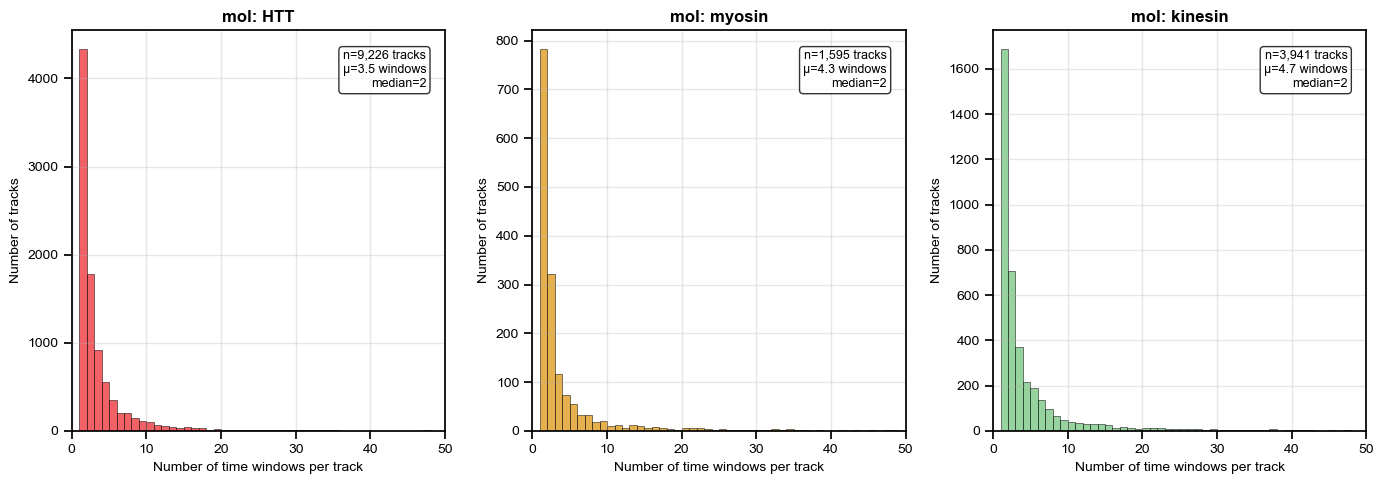

In [6]:
# Plot histogram of windows per track, separated by molecule
fig, axes, stats = spt.plot_windows_per_track_histogram(
    windowed_df_classified_noungated,
    group_by='mol',
    save_path=saved_dir,
    figsize=(14, 5),
    color_palette=raiders_colors2,
    transparent_background=True,
    max_windows=50,  # Focus on first 50 windows for visualization
    export_format='svg'
)

# Print statistics
print("\n" + "="*80)
print("WINDOWS PER TRACK STATISTICS")
print("="*80)
for mol, stat in stats.items():
    print(f"\n{mol}:")
    print(f"  Total tracks: {stat['n_tracks']:,}")
    print(f"  Mean windows: {stat['mean_windows']:.1f}")
    print(f"  Median windows: {stat['median_windows']:.0f}")
    print(f"  Range: {stat['min_windows']:.0f} - {stat['max_windows']:.0f}")
    print(f"  Total windows: {stat['total_windows']:,}")


fixed windows

In [7]:
### APPROACH B: Fixed-Length Segments (New Method)
# Divide tracks into segments of equal length for fair comparison

# Set segment length (adjust based on your data)
SEGMENT_LENGTH = 10  # Each segment will have exactly 10 windows

# Create fixed-length segments
segment_df = spt.create_fixed_length_track_segments(
    windowed_df_classified_noungated,
    segment_length=SEGMENT_LENGTH,
    state_col='final_population',
    unique_id_col='unique_id',
    time_col='time_window',
    additional_cols=['mol', 'type', 'geno', 'group'],
    min_segments=1  # Require at least 1 complete segment per track
)

print("\nExample segments:")
if isinstance(segment_df, pl.DataFrame):
    print(segment_df.head(5))
else:
    print(segment_df.head(5))
# Diagnose fixed-length segments
diagnostics_fixed = spt.diagnose_state_sequences(
    segment_df,
    sequence_col='state_sequence',
    unique_id_col='segment_id'  # Note: using segment_id instead of unique_id
)

print("\n💡 Fixed-length segments ensure all tracks have the same temporal coverage")
print("   This makes similarity and transition analysis more comparable across tracks")


FIXED-LENGTH TRACK SEGMENTATION
Segment length: 10 windows
Original tracks: 14,762
Tracks with ≥1 segment(s): 1,196
Total segments created: 2,245
Avg segments per track: 1.9

Segments per track:
  Min: 1
  Max: 12
  Mean: 1.9
  Median: 1


Example segments:
shape: (5, 9)
┌────────────────┬───────────────┬───────────────┬───────────────┬───┬─────┬──────┬────────┬───────┐
│ segment_id     ┆ original_trac ┆ segment_numbe ┆ state_sequenc ┆ … ┆ mol ┆ type ┆ geno   ┆ group │
│ ---            ┆ k_id          ┆ r             ┆ e             ┆   ┆ --- ┆ ---  ┆ ---    ┆ ---   │
│ str            ┆ ---           ┆ ---           ┆ ---           ┆   ┆ str ┆ str  ┆ str    ┆ str   │
│                ┆ str           ┆ i64           ┆ object        ┆   ┆     ┆      ┆        ┆       │
╞════════════════╪═══════════════╪═══════════════╪═══════════════╪═══╪═════╪══════╪════════╪═══════╡
│ eeh2h_0_17_R1_ ┆ eeh2h_0_17_R1 ┆ 0             ┆ ['fast_explor ┆ … ┆ HTT ┆ ES   ┆ 20H20S ┆ HTT77 │
│ seg0           ┆  

In [8]:
### Convert segments to windowed format for transition analysis

print("📊 Creating windowed representation from fixed-length segments...")

segment_rows = []

if isinstance(segment_df, pl.DataFrame):
    seg_pd = segment_df.to_pandas()
else:
    seg_pd = segment_df.copy()

for idx, row in seg_pd.iterrows():
    segment_id = row['segment_id']
    states = row['state_sequence']
    
    # Ensure states is a Python list
    if not isinstance(states, list):
        states = list(states)
    
    # Create windowed rows for this segment
    for window_idx, state in enumerate(states):
        segment_rows.append({
            'segment_id': segment_id,
            'time_window': window_idx,
            'final_population': state,
            'mol': row['mol'],
            'type': row['type'],
            'geno': row['geno'],
            'group': row['group'],
            'original_track_id': row['original_track_id'],
            'segment_number': row['segment_number'],
            'n_windows': row['n_windows']
        })

# Create windowed-style dataframe
segment_windowed_df = pd.DataFrame(segment_rows)

if isinstance(segment_df, pl.DataFrame):
    segment_windowed_df = pl.from_pandas(segment_windowed_df)

print(f"✅ Created windowed representation: {len(segment_windowed_df):,} rows")
print(f"   Representing {segment_windowed_df['segment_id'].n_unique() if isinstance(segment_windowed_df, pl.DataFrame) else segment_windowed_df['segment_id'].nunique():,} segments")

📊 Creating windowed representation from fixed-length segments...
✅ Created windowed representation: 22,450 rows
   Representing 2,245 segments


In [9]:
transition_results = spt.analyze_state_transitions(
    segment_windowed_df,
    state_col='final_population',
    unique_id_col='segment_id',
    time_col='time_window',
    group_by='mol',
    normalize=True,
    min_windows=2
)

# Print summary
print("\n" + "="*80)
print("STATE TRANSITION SUMMARY BY MOLECULE (Fixed-Length Segments)")
print("="*80)
print(f"Each segment has exactly {SEGMENT_LENGTH} windows\n")

for mol, result in transition_results.items():
    print(f"\n{'─'*80}")
    print(f"MOLECULE: {mol}")
    print(f"{'─'*80}")
    stats = result['stats']
    print(f"Segments analyzed: {stats['n_tracks']:,}")
    print(f"Total transitions: {stats['n_transitions']:,}")
    print(f"Avg transitions per segment: {stats['avg_transitions_per_track']:.2f}")
    print(f"Max possible transitions: {SEGMENT_LENGTH - 1}")
    print(f"\nStates observed: {', '.join(stats['states'])}")
    
    print("\n🔄 Most common transitions:")
    top_transitions = result['transitions_summary'].head(10)
    for idx, row in top_transitions.iterrows():
        arrow = "→" if not row['is_self_transition'] else "↻"
        print(f"  {row['from_state']} {arrow} {row['to_state']}: "
              f"{row['count']:,} transitions ({row['probability']:.1%})")
    
    print("\n📌 State persistence (probability of staying in same state):")
    for state, persistence in sorted(stats['state_persistence'].items(), 
                                    key=lambda x: x[1], reverse=True):
        print(f"  {state}: {persistence:.1%}")


STATE TRANSITION SUMMARY BY MOLECULE (Fixed-Length Segments)
Each segment has exactly 10 windows


────────────────────────────────────────────────────────────────────────────────
MOLECULE: HTT
────────────────────────────────────────────────────────────────────────────────
Segments analyzed: 1,062
Total transitions: 9,558
Avg transitions per segment: 9.00
Max possible transitions: 9

States observed: bound_stationary, fast_exploratory, mixed_exploratory_bound, subdiffusive_motion, superdiffusive_transport

🔄 Most common transitions:
  bound_stationary ↻ bound_stationary: 3,362 transitions (86.1%)
  fast_exploratory ↻ fast_exploratory: 3,079 transitions (86.6%)
  subdiffusive_motion ↻ subdiffusive_motion: 1,246 transitions (63.4%)
  subdiffusive_motion → bound_stationary: 431 transitions (21.9%)
  bound_stationary → subdiffusive_motion: 415 transitions (10.6%)
  fast_exploratory → subdiffusive_motion: 293 transitions (8.2%)
  subdiffusive_motion → fast_exploratory: 232 transitions (11


Plotting transition matrix for HTT...
✅ Saved transition matrix to: F:/plots/plasticity/transition_matrix_probabilities_HTT.svg


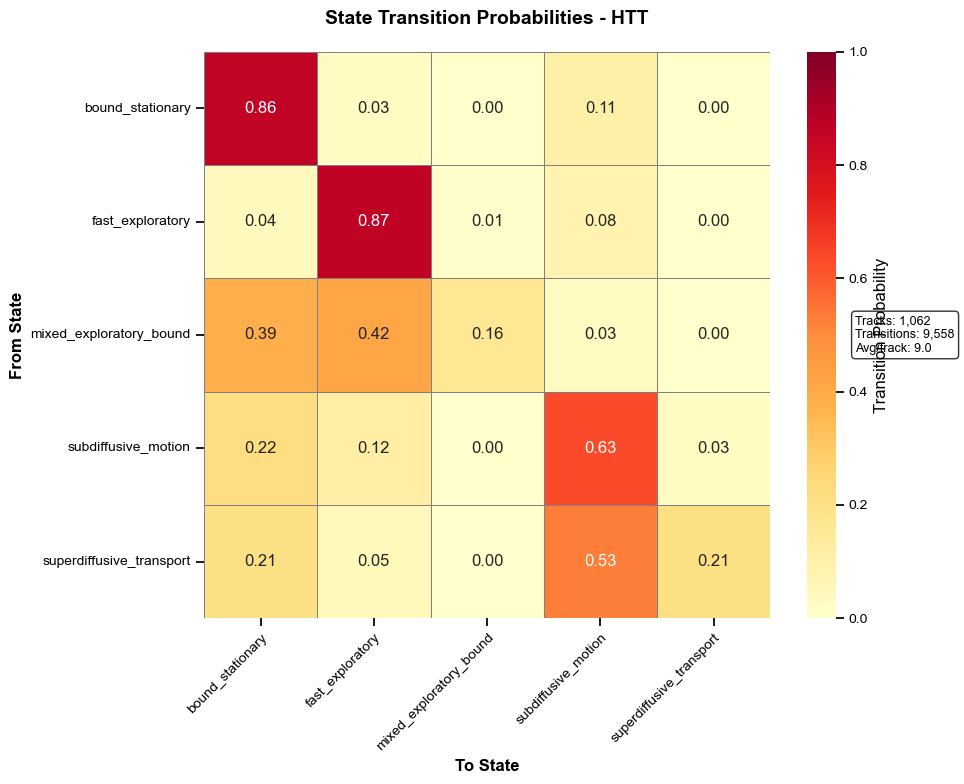

✅ Saved transition matrix to: F:/plots/plasticity/transition_matrix_counts_HTT.svg


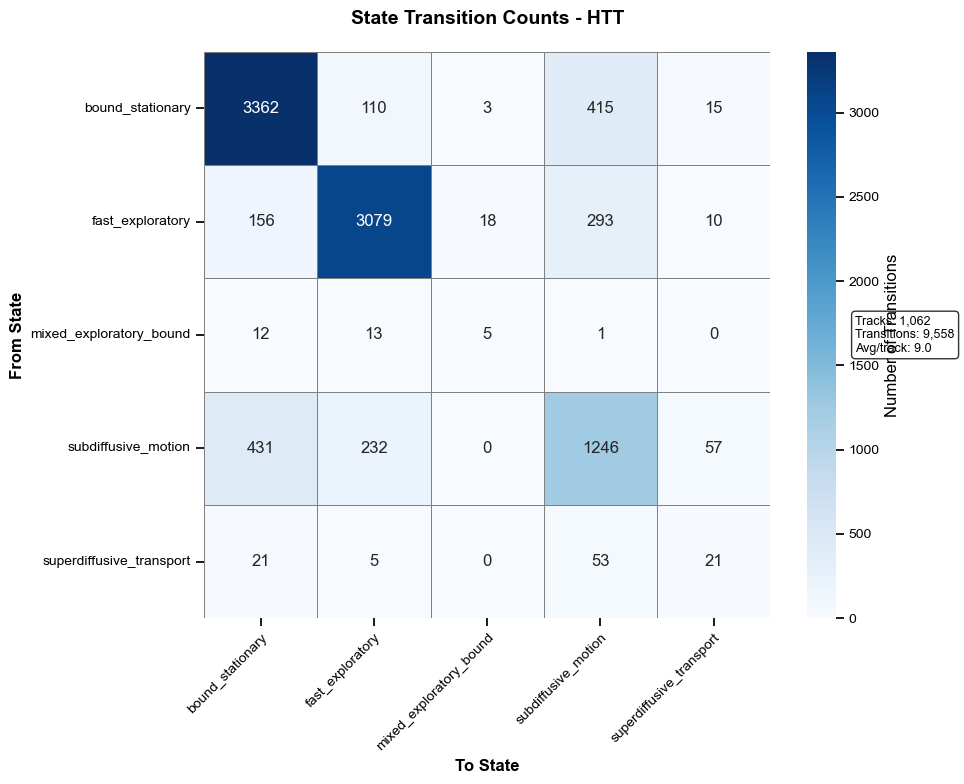


Plotting transition matrix for kinesin...
✅ Saved transition matrix to: F:/plots/plasticity/transition_matrix_probabilities_kinesin.svg


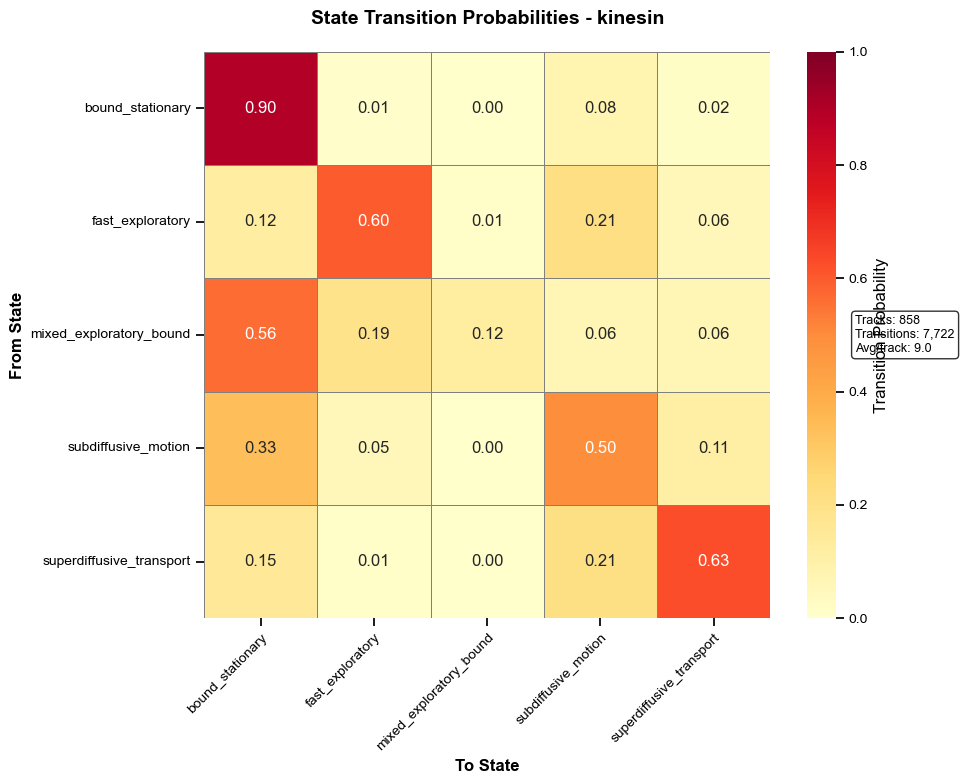

✅ Saved transition matrix to: F:/plots/plasticity/transition_matrix_counts_kinesin.svg


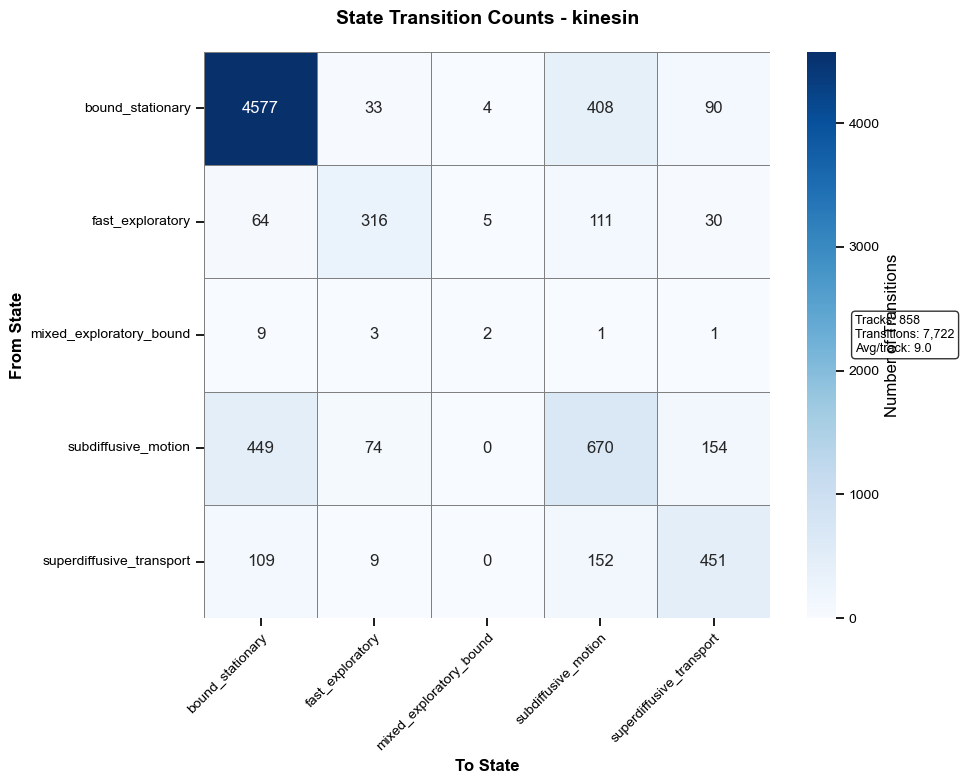


Plotting transition matrix for myosin...
✅ Saved transition matrix to: F:/plots/plasticity/transition_matrix_probabilities_myosin.svg


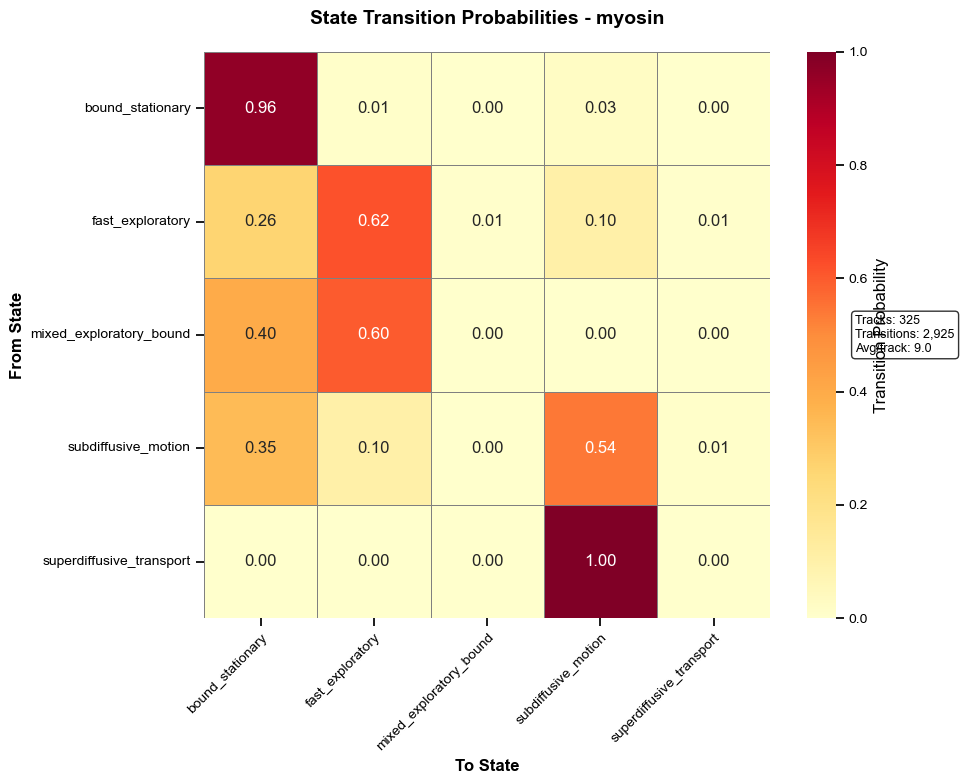

✅ Saved transition matrix to: F:/plots/plasticity/transition_matrix_counts_myosin.svg


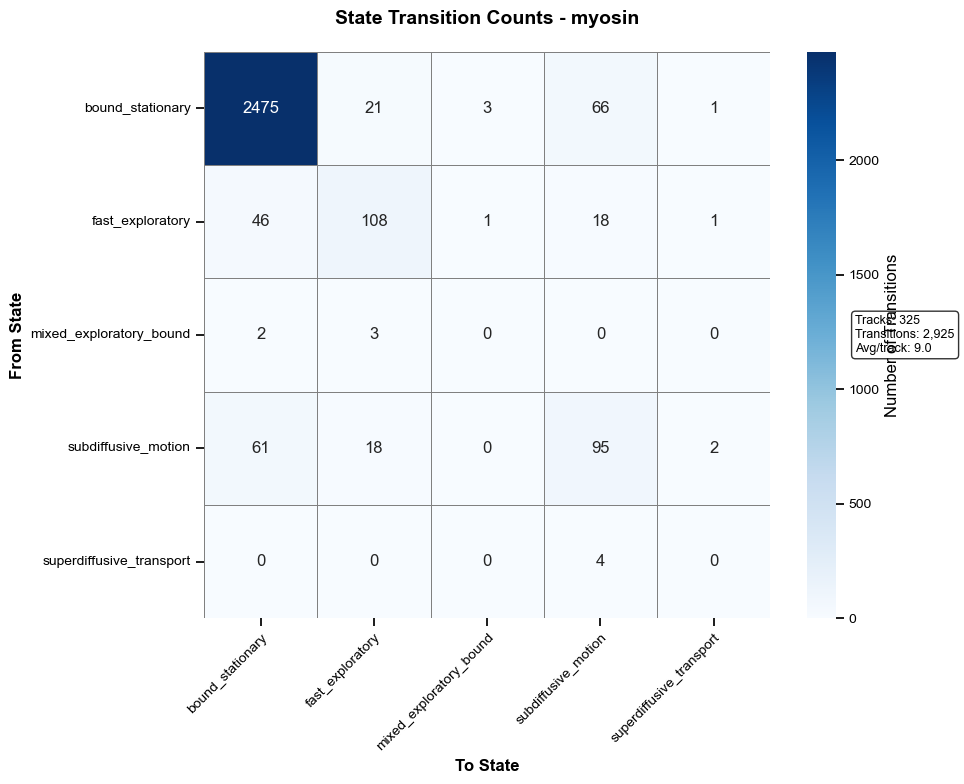

In [12]:
### Plot transition matrices

for mol, result in transition_results.items():
    print(f"\nPlotting transition matrix for {mol}...")
    
    # Plot probabilities
    fig, ax = spt.plot_transition_matrix(
        result,
        figsize=(10, 8),
        cmap='YlOrRd',
        save_path=saved_dir,
        export_format='svg',
        show_counts=False
    )
    plt.show()
    
    # Plot counts
    fig, ax = spt.plot_transition_matrix(
        result,
        figsize=(10, 8),
        cmap='Blues',
        save_path=saved_dir,
        export_format='svg',
        show_counts=True
    )
    plt.show()

In [13]:
transition_counts_segments = spt.count_state_transitions_per_track(
    segment_windowed_df,
    state_col='final_population',
    unique_id_col='segment_id',
    time_col='time_window',
    additional_cols=['mol', 'type', 'geno', 'group', 'original_track_id', 'segment_number']
)

# Summary statistics
print("\n" + "="*80)
print("TRANSITION COUNTS PER SEGMENT - SUMMARY")
print("="*80)
print(f"Each segment has exactly {SEGMENT_LENGTH} windows")
print(f"Max possible transitions per segment: {SEGMENT_LENGTH - 1}\n")

if isinstance(transition_counts_segments, pl.DataFrame):
    summary = transition_counts_segments.group_by('mol').agg([
        pl.col('n_transitions').mean().alias('mean_transitions'),
        pl.col('n_transitions').median().alias('median_transitions'),
        pl.col('n_transitions').std().alias('std_transitions'),
        pl.col('transition_rate').mean().alias('mean_transition_rate'),
        pl.col('n_unique_states').mean().alias('mean_unique_states'),
        pl.len().alias('n_segments')
    ]).sort('mol')
    print(summary)
else:
    summary = transition_counts_segments.groupby('mol').agg({
        'n_transitions': ['mean', 'median', 'std'],
        'transition_rate': 'mean',
        'n_unique_states': 'mean',
        'segment_id': 'count'
    }).round(2)
    print(summary)


TRANSITION COUNTS PER SEGMENT - SUMMARY
Each segment has exactly 10 windows
Max possible transitions per segment: 9

shape: (3, 7)
┌─────────┬───────────────┬──────────────┬──────────────┬──────────────┬──────────────┬────────────┐
│ mol     ┆ mean_transiti ┆ median_trans ┆ std_transiti ┆ mean_transit ┆ mean_unique_ ┆ n_segments │
│ ---     ┆ ons           ┆ itions       ┆ ons          ┆ ion_rate     ┆ states       ┆ ---        │
│ str     ┆ ---           ┆ ---          ┆ ---          ┆ ---          ┆ ---          ┆ u32        │
│         ┆ f64           ┆ f64          ┆ f64          ┆ f64          ┆ f64          ┆            │
╞═════════╪═══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪════════════╡
│ HTT     ┆ 1.737288      ┆ 1.0          ┆ 1.788987     ┆ 0.193032     ┆ 1.889831     ┆ 1062       │
│ kinesin ┆ 1.988345      ┆ 2.0          ┆ 1.944349     ┆ 0.220927     ┆ 2.037296     ┆ 858        │
│ myosin  ┆ 0.76          ┆ 0.0          ┆ 1.371311     ┆ 0.

✅ Saved transition counts comparison to: F:/plots/plasticity/transition_counts_comparison_mol.svg


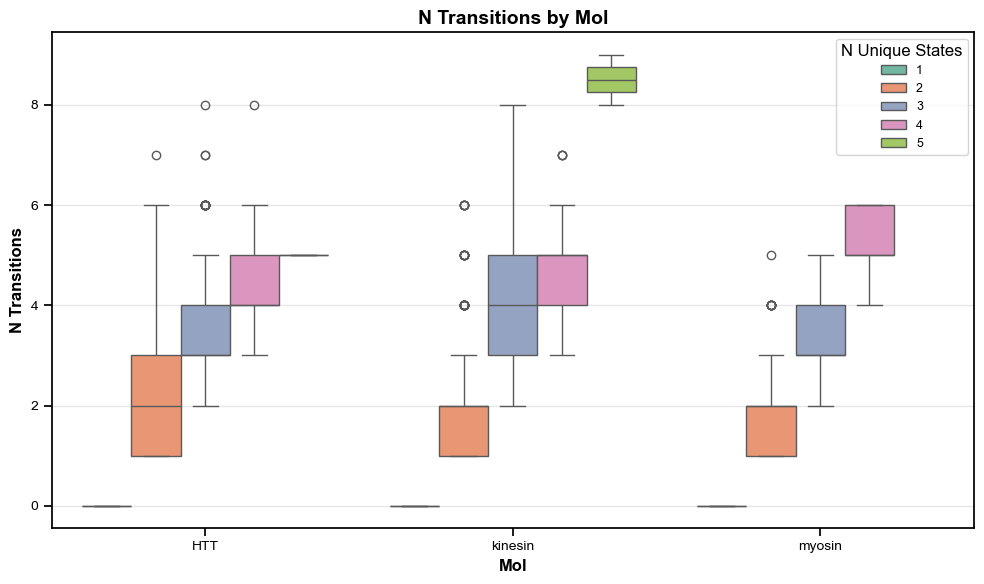

✅ Saved transition counts comparison to: F:/plots/plasticity/transition_counts_comparison_mol.svg


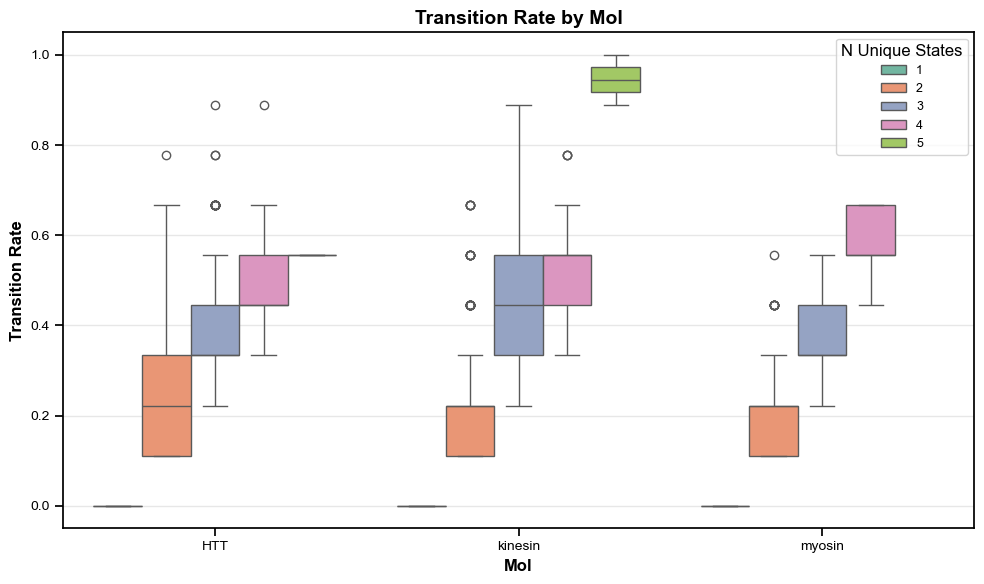

In [14]:
# Plot number of transitions
fig, ax = spt.plot_transition_counts_comparison(
    transition_counts_segments,
    x='mol',
    hue='n_unique_states',
    y='n_transitions',
    figsize=(10, 6),
    palette='Set2',
    save_path=saved_dir,
    export_format='svg'
)
plt.show()

# Plot transition rate
fig, ax = spt.plot_transition_counts_comparison(
    transition_counts_segments,
    x='mol',
    hue='n_unique_states',
    y='transition_rate',
    figsize=(10, 6),
    palette='Set2',
    save_path=saved_dir,
    export_format='svg'
)
plt.show()

In [15]:
# Set window duration (adjust to your data)
WINDOW_DURATION_SECONDS = 6.0  # seconds per window

dwell_results = spt.analyze_state_dwell_times(
    segment_windowed_df,
    state_col='final_population',
    unique_id_col='segment_id',
    time_col='time_window',
    window_duration=WINDOW_DURATION_SECONDS,
    group_by='mol'
)

# Print summary
print("\n" + "="*80)
print("STATE DWELL TIME ANALYSIS (Fixed-Length Segments)")
print("="*80)
print(f"Each segment: {SEGMENT_LENGTH} windows = {SEGMENT_LENGTH * WINDOW_DURATION_SECONDS:.0f}s\n")

for mol, result in dwell_results.items():
    print(f"\n{'─'*80}")
    print(f"MOLECULE: {mol}")
    print(f"{'─'*80}")
    
    summary_stats = result['summary_stats']
    if len(summary_stats) > 0:
        print("\nDwell time statistics (windows):")
        print(summary_stats[['state', 'n_visits', 'n_tracks', 'mean_dwell', 
                            'median_dwell', 'std_dwell']].to_string(index=False))
        
        if 'mean_duration_s' in summary_stats.columns:
            print("\nDwell time statistics (seconds):")
            print(summary_stats[['state', 'mean_duration_s', 'median_duration_s', 
                                'std_duration_s']].to_string(index=False))
    else:
        print("No dwell time data available")


STATE DWELL TIME ANALYSIS (Fixed-Length Segments)
Each segment: 10 windows = 60s


────────────────────────────────────────────────────────────────────────────────
MOLECULE: HTT
────────────────────────────────────────────────────────────────────────────────

Dwell time statistics (windows):
                   state  n_visits  n_tracks  mean_dwell  median_dwell  std_dwell
        bound_stationary       978       702    4.437628           3.0   3.564107
        fast_exploratory       854       633    4.605386           3.0   3.470528
 mixed_exploratory_bound        31        29    1.161290           1.0   0.373878
     subdiffusive_motion       950       559    2.311579           2.0   1.890516
superdiffusive_transport        94        84    1.223404           1.0   0.607379

Dwell time statistics (seconds):
                   state  mean_duration_s  median_duration_s  std_duration_s
        bound_stationary        26.625767               18.0       21.384644
        fast_exploratory  


Plotting dwell time distributions for HTT...
✅ Saved dwell time distributions to: F:/plots/plasticity/dwell_time_distributions_HTT.svg


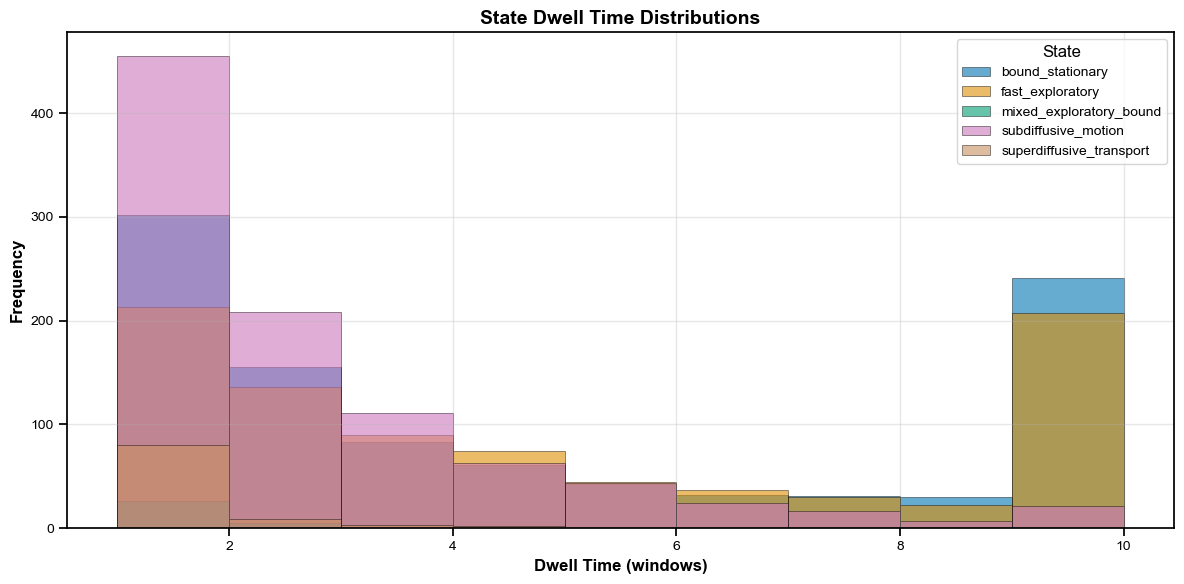


Plotting dwell time distributions for kinesin...
✅ Saved dwell time distributions to: F:/plots/plasticity/dwell_time_distributions_kinesin.svg


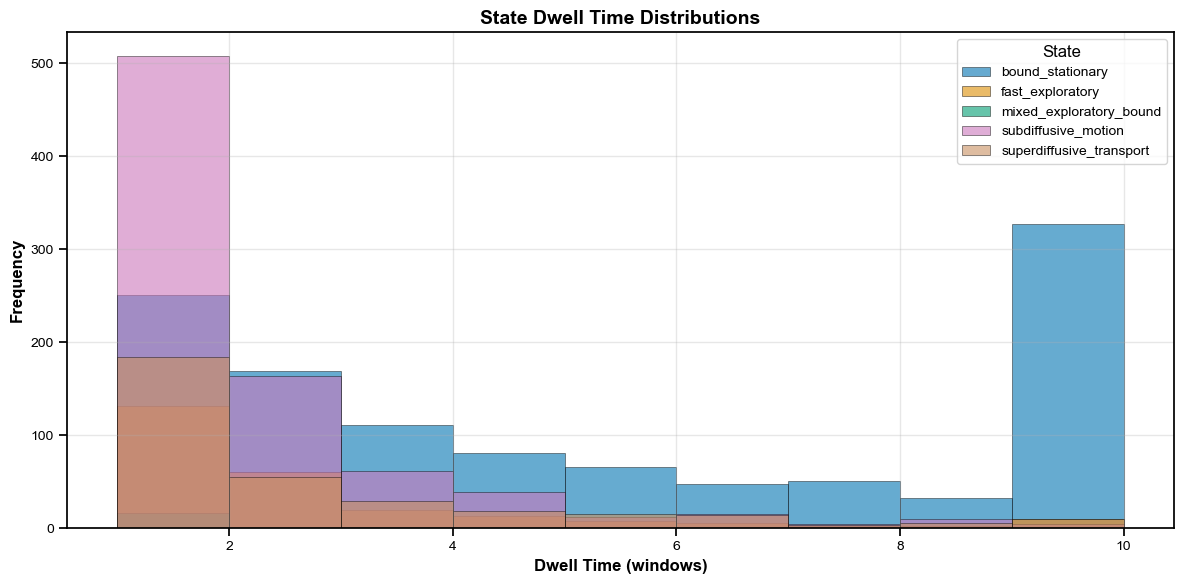


Plotting dwell time distributions for myosin...
✅ Saved dwell time distributions to: F:/plots/plasticity/dwell_time_distributions_myosin.svg


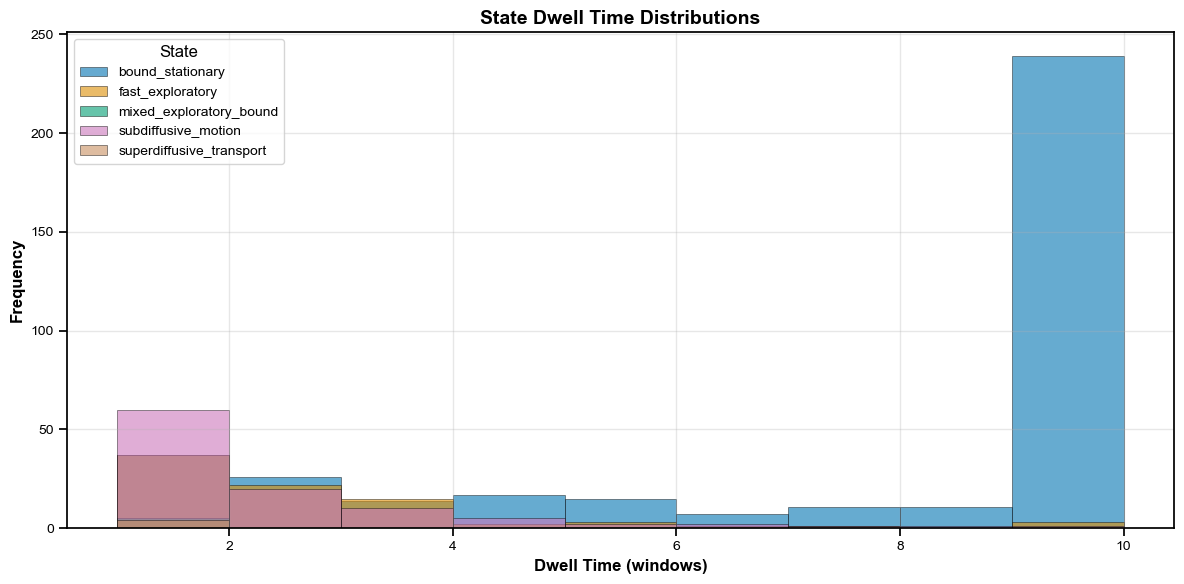

In [16]:
### Plot dwell time distributions

for mol, result in dwell_results.items():
    print(f"\nPlotting dwell time distributions for {mol}...")
    
    fig, ax = spt.plot_dwell_time_distributions(
        result,
        figsize=(12, 6),
        color_palette=colorblind_colors,
        save_path=saved_dir,
        export_format='svg',
        bins=range(1, SEGMENT_LENGTH + 1)
    )
    if fig:
        plt.show()

In [18]:
### Calculate segment similarity (Damerau-Levenshtein distance)

# This requires python-Levenshtein and pyxdameraulevenshtein packages
# pip install python-Levenshtein pyxdameraulevenshtein

mols = ['HTT', 'kinesin','myosin']

SAMPLE_SIZE_PER_MOL = 100  # Adjust based on computational resources

similarity_results = {}

for mol in mols:
    print(f"\n{'='*80}")
    print(f"Calculating segment similarity for {mol}")
    print(f"{'='*80}")
    
    # Filter to this molecule
    if isinstance(segment_df, pl.DataFrame):
        mol_segments = segment_df.filter(pl.col('mol') == mol)
    else:
        mol_segments = segment_df[segment_df['mol'] == mol]
    
    # Calculate similarity
    try:
        similarity_result = spt.calculate_track_similarity(
            mol_segments,
            sequence_col='state_sequence',
            unique_id_col='segment_id',
            method='damerau_levenshtein',
            normalize=True,
            sample_size=min(SAMPLE_SIZE_PER_MOL, len(mol_segments)),
            random_seed=42
        )
        
        similarity_results[mol] = similarity_result
        
        print(f"\n📊 Statistics for {mol}:")
        print(f"  Segments compared: {similarity_result['stats']['n_tracks']}")
        print(f"  Average similarity: {similarity_result['stats']['avg_similarity']:.3f}")
        print(f"  Similarity range: {similarity_result['stats']['min_similarity']:.3f} - {similarity_result['stats']['max_similarity']:.3f}")
        
    except Exception as e:
        print(f"⚠️  Error calculating similarity for {mol}: {e}")
        print("   Install packages: pip install python-Levenshtein pyxdameraulevenshtein")


Calculating segment similarity for HTT
Sampled 100 tracks for similarity calculation
Calculating pairwise damerau_levenshtein distances for 100 tracks...


Computing similarities:   0%|          | 0/100 [00:00<?, ?it/s]


✅ Similarity analysis complete!
   Average pairwise similarity: 0.391
   Average pairwise distance: 0.609

📊 Statistics for HTT:
  Segments compared: 100
  Average similarity: 0.391
  Similarity range: 0.000 - 1.000

Calculating segment similarity for kinesin
Sampled 100 tracks for similarity calculation
Calculating pairwise damerau_levenshtein distances for 100 tracks...


Computing similarities:   0%|          | 0/100 [00:00<?, ?it/s]


✅ Similarity analysis complete!
   Average pairwise similarity: 0.531
   Average pairwise distance: 0.469

📊 Statistics for kinesin:
  Segments compared: 100
  Average similarity: 0.531
  Similarity range: 0.000 - 1.000

Calculating segment similarity for myosin
Sampled 100 tracks for similarity calculation
Calculating pairwise damerau_levenshtein distances for 100 tracks...


Computing similarities:   0%|          | 0/100 [00:00<?, ?it/s]


✅ Similarity analysis complete!
   Average pairwise similarity: 0.794
   Average pairwise distance: 0.206

📊 Statistics for myosin:
  Segments compared: 100
  Average similarity: 0.794
  Similarity range: 0.000 - 1.000



Plotting similarity matrix for HTT...
✅ Saved to: F:/plots/plasticity/similarity_matrix_HTT_seg10.svg


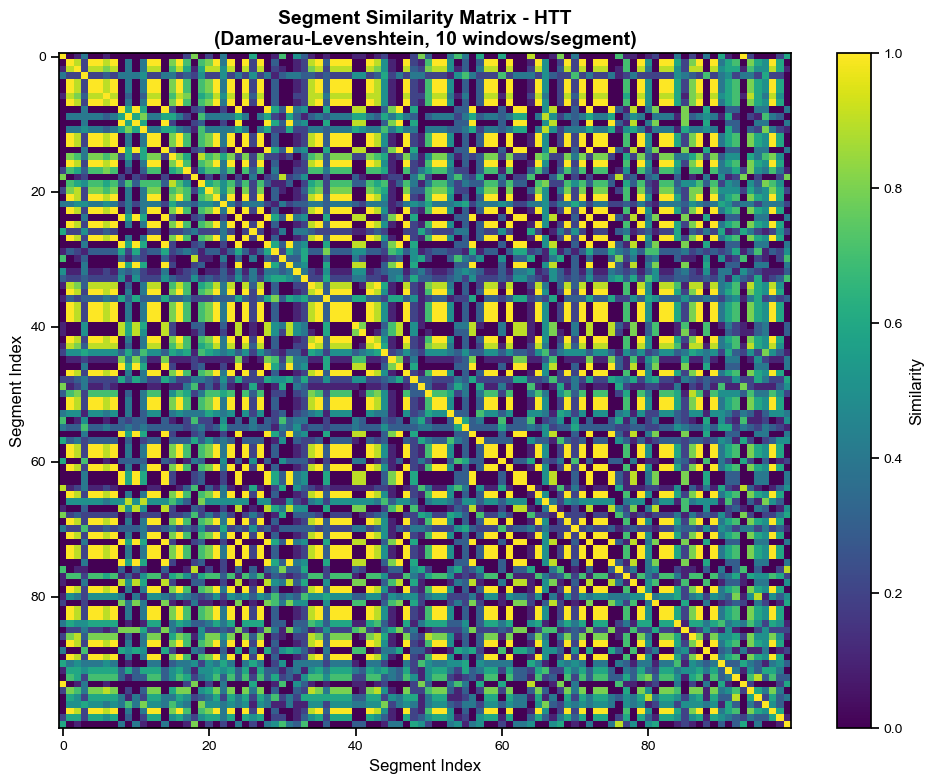


Plotting similarity matrix for kinesin...
✅ Saved to: F:/plots/plasticity/similarity_matrix_kinesin_seg10.svg


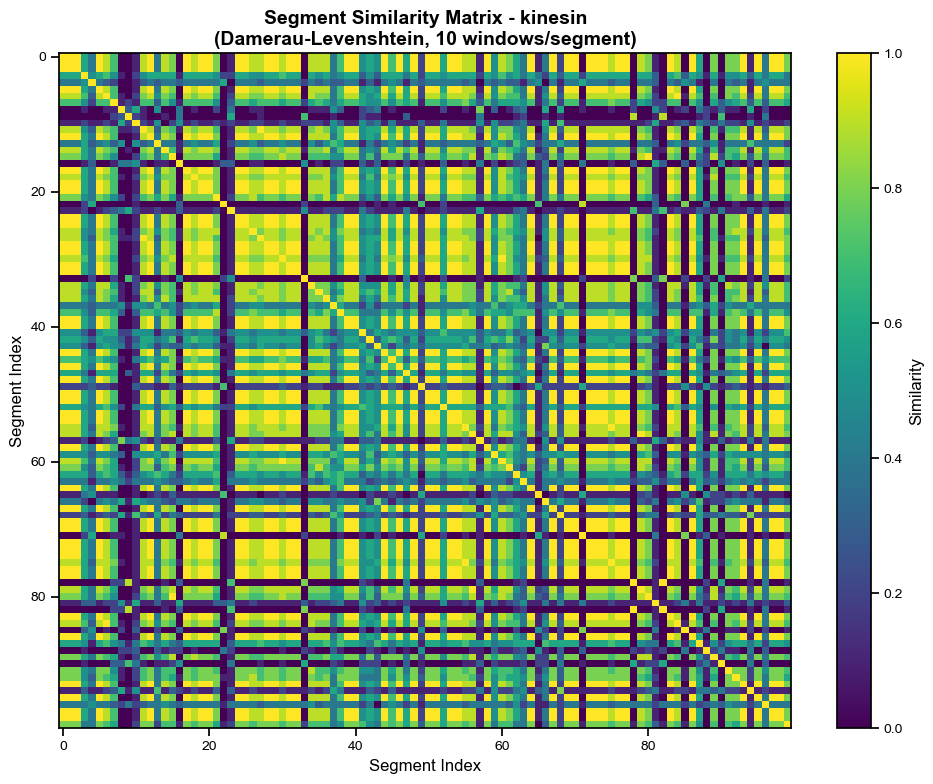


Plotting similarity matrix for myosin...
✅ Saved to: F:/plots/plasticity/similarity_matrix_myosin_seg10.svg


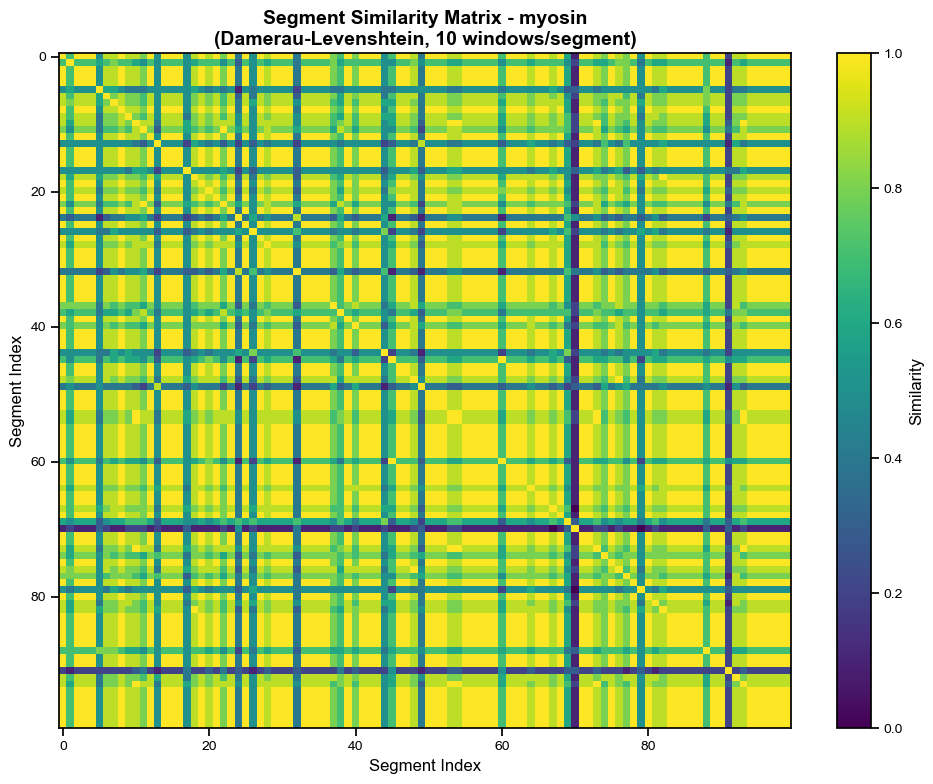

In [19]:
### Plot similarity matrices (if similarity was calculated)

if len(similarity_results) > 0:
    for mol, result in similarity_results.items():
        print(f"\nPlotting similarity matrix for {mol}...")
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Plot similarity matrix
        im = ax.imshow(result['similarity_matrix'].values, cmap='viridis', aspect='auto')
        
        ax.set_title(f'Segment Similarity Matrix - {mol}\n(Damerau-Levenshtein, {SEGMENT_LENGTH} windows/segment)', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Segment Index', fontsize=12)
        ax.set_ylabel('Segment Index', fontsize=12)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Similarity', fontsize=12)
        
        # Save
        plt.tight_layout()
        if saved_dir:
            filename = f"similarity_matrix_{mol}_seg{SEGMENT_LENGTH}.svg"
            full_path = os.path.join(saved_dir, filename)
            plt.savefig(full_path, dpi=300, bbox_inches='tight', transparent=True)
            print(f"✅ Saved to: {full_path}")
        
        plt.show()

In [20]:
### Create comprehensive summary table

print("\n" + "="*80)
print("COMPREHENSIVE TRANSITION ANALYSIS SUMMARY")
print("="*80)
print(f"Analysis Method: Fixed-Length Segments ({SEGMENT_LENGTH} windows each)\n")

summary_data = []

for mol in mols:
    if mol in transition_results:
        trans_stats = transition_results[mol]['stats']
        
        # Get transition counts summary
        if isinstance(transition_counts_segments, pl.DataFrame):
            mol_trans = transition_counts_segments.filter(pl.col('mol') == mol)
            avg_transitions = mol_trans['n_transitions'].mean()
            avg_rate = mol_trans['transition_rate'].mean()
            avg_unique_states = mol_trans['n_unique_states'].mean()
        else:
            mol_trans = transition_counts_segments[transition_counts_segments['mol'] == mol]
            avg_transitions = mol_trans['n_transitions'].mean()
            avg_rate = mol_trans['transition_rate'].mean()
            avg_unique_states = mol_trans['n_unique_states'].mean()
        
        # Get dwell time info
        if mol in dwell_results and len(dwell_results[mol]['summary_stats']) > 0:
            avg_dwell = dwell_results[mol]['summary_stats']['mean_dwell'].mean()
        else:
            avg_dwell = np.nan
        
        # Get similarity info
        if mol in similarity_results:
            avg_similarity = similarity_results[mol]['stats']['avg_similarity']
        else:
            avg_similarity = np.nan
        
        summary_data.append({
            'Molecule': mol,
            'N Segments': trans_stats['n_tracks'],
            'Total Transitions': trans_stats['n_transitions'],
            'Avg Trans/Segment': avg_transitions,
            'Transition Rate': avg_rate,
            'Avg Unique States': avg_unique_states,
            'Avg Dwell (windows)': avg_dwell,
            'Avg Similarity': avg_similarity
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("="*80)

# Save summary
if saved_dir:
    summary_path = os.path.join(saved_dir, f'transition_analysis_summary_seg{SEGMENT_LENGTH}.csv')
    summary_df.to_csv(summary_path, index=False)
    print(f"\n✅ Saved summary to: {summary_path}")


COMPREHENSIVE TRANSITION ANALYSIS SUMMARY
Analysis Method: Fixed-Length Segments (10 windows each)

Molecule  N Segments  Total Transitions  Avg Trans/Segment  Transition Rate  Avg Unique States  Avg Dwell (windows)  Avg Similarity
     HTT        1062               9558           1.737288         0.193032           1.889831             2.747858        0.391253
 kinesin         858               7722           1.988345         0.220927           2.037296             2.509316        0.530909
  myosin         325               2925           0.760000         0.084444           1.418462             2.756415        0.793636

✅ Saved summary to: F:/plots/plasticity/transition_analysis_summary_seg10.csv


Across molecules

In [21]:
### Compare transition rates across molecules

print("="*80)
print("MOLECULAR COMPARISON: TRANSITION RATES")
print("="*80)
print(f"Based on {SEGMENT_LENGTH}-window segments\n")

# Extract transition rate data by molecule
transition_rate_data = {}

if isinstance(transition_counts_segments, pl.DataFrame):
    for mol in mols:
        mol_data = transition_counts_segments.filter(pl.col('mol') == mol)
        transition_rate_data[mol] = {
            'rates': mol_data['transition_rate'].to_list(),
            'n_segments': len(mol_data),
            'mean_rate': mol_data['transition_rate'].mean(),
            'median_rate': mol_data['transition_rate'].median(),
            'std_rate': mol_data['transition_rate'].std()
        }
else:
    for mol in mols:
        mol_data = transition_counts_segments[transition_counts_segments['mol'] == mol]
        transition_rate_data[mol] = {
            'rates': mol_data['transition_rate'].tolist(),
            'n_segments': len(mol_data),
            'mean_rate': mol_data['transition_rate'].mean(),
            'median_rate': mol_data['transition_rate'].median(),
            'std_rate': mol_data['transition_rate'].std()
        }

# Display comparison
print("\nTransition Rate Summary:")
print(f"{'Molecule':<15} {'N Segments':<12} {'Mean Rate':<12} {'Median Rate':<12} {'Std Dev':<12}")
print("-"*80)

for mol in mols:
    data = transition_rate_data[mol]
    print(f"{mol:<15} {data['n_segments']:<12,} {data['mean_rate']:<12.3f} "
          f"{data['median_rate']:<12.3f} {data['std_rate']:<12.3f}")

print("\n💡 Interpretation:")
print("   Higher transition rate = More plastic (changes states frequently)")
print("   Lower transition rate = More stable (stays in same state)")

MOLECULAR COMPARISON: TRANSITION RATES
Based on 10-window segments


Transition Rate Summary:
Molecule        N Segments   Mean Rate    Median Rate  Std Dev     
--------------------------------------------------------------------------------
HTT             1,062        0.193        0.111        0.199       
kinesin         858          0.221        0.222        0.216       
myosin          325          0.084        0.000        0.152       

💡 Interpretation:
   Higher transition rate = More plastic (changes states frequently)
   Lower transition rate = More stable (stays in same state)


In [22]:
### Compare state persistence across molecules

print("\n" + "="*80)
print("MOLECULAR COMPARISON: STATE PERSISTENCE")
print("="*80)

persistence_comparison = []

for mol in mols:
    if mol in transition_results:
        persistence = transition_results[mol]['stats']['state_persistence']
        
        for state, prob in persistence.items():
            persistence_comparison.append({
                'Molecule': mol,
                'State': state,
                'Persistence_Probability': prob,
                'Rank': None  # Will fill this in
            })

persistence_df = pd.DataFrame(persistence_comparison)

# Rank within each state
for state in persistence_df['State'].unique():
    state_mask = persistence_df['State'] == state
    persistence_df.loc[state_mask, 'Rank'] = persistence_df.loc[state_mask, 'Persistence_Probability'].rank(ascending=False)

# Display by state
print("\nState Persistence by Molecule:")
print("="*80)

for state in sorted(persistence_df['State'].unique()):
    print(f"\n{state}:")
    state_data = persistence_df[persistence_df['State'] == state].sort_values('Persistence_Probability', ascending=False)
    
    for idx, row in state_data.iterrows():
        rank_emoji = "🥇" if row['Rank'] == 1 else ("🥈" if row['Rank'] == 2 else ("🥉" if row['Rank'] == 3 else "  "))
        print(f"  {rank_emoji} {row['Molecule']:<15} {row['Persistence_Probability']:>6.1%}")

print("\n💡 Interpretation:")
print("   Higher persistence = Stable in that state")
print("   Lower persistence = Frequently exits that state")


MOLECULAR COMPARISON: STATE PERSISTENCE

State Persistence by Molecule:

bound_stationary:
  🥇 myosin           96.5%
  🥈 kinesin          89.5%
  🥉 HTT              86.1%

fast_exploratory:
  🥇 HTT              86.6%
  🥈 myosin           62.1%
  🥉 kinesin          60.1%

mixed_exploratory_bound:
  🥇 HTT              16.1%
  🥈 kinesin          12.5%
  🥉 myosin            0.0%

subdiffusive_motion:
  🥇 HTT              63.4%
  🥈 myosin           54.0%
  🥉 kinesin          49.7%

superdiffusive_transport:
  🥇 kinesin          62.6%
  🥈 HTT              21.0%
  🥉 myosin            0.0%

💡 Interpretation:
   Higher persistence = Stable in that state
   Lower persistence = Frequently exits that state


In [23]:
### Compare similarity scores (if calculated)

if len(similarity_results) > 0:
    print("\n" + "="*80)
    print("MOLECULAR COMPARISON: BEHAVIORAL SIMILARITY")
    print("="*80)
    
    similarity_comparison = []
    
    for mol in mols:
        if mol in similarity_results:
            stats = similarity_results[mol]['stats']
            similarity_comparison.append({
                'Molecule': mol,
                'Avg_Similarity': stats['avg_similarity'],
                'Std_Similarity': stats['std_similarity'],
                'N_Segments': stats['n_tracks']
            })
    
    sim_df = pd.DataFrame(similarity_comparison).sort_values('Avg_Similarity', ascending=False)
    
    print("\nAverage Pairwise Similarity:")
    print(f"{'Molecule':<15} {'N Segments':<12} {'Avg Similarity':<15} {'Std Dev':<12} {'Interpretation':<20}")
    print("-"*80)
    
    for idx, row in sim_df.iterrows():
        if row['Avg_Similarity'] > 0.8:
            interp = "Highly stereotyped"
        elif row['Avg_Similarity'] > 0.6:
            interp = "Moderately consistent"
        else:
            interp = "Highly diverse"
        
        print(f"{row['Molecule']:<15} {row['N_Segments']:<12,} {row['Avg_Similarity']:<15.3f} "
              f"{row['Std_Similarity']:<12.3f} {interp:<20}")
    
    print("\n💡 Interpretation:")
    print("   Higher similarity = Stereotyped behavior (tracks behave similarly)")
    print("   Lower similarity = Diverse behavior (tracks vary widely)")
else:
    print("\n⚠️  Similarity analysis not performed. Run the similarity cell to enable this comparison.")


MOLECULAR COMPARISON: BEHAVIORAL SIMILARITY

Average Pairwise Similarity:
Molecule        N Segments   Avg Similarity  Std Dev      Interpretation      
--------------------------------------------------------------------------------
myosin          100          0.794           0.236        Moderately consistent
kinesin         100          0.531           0.360        Highly diverse      
HTT             100          0.391           0.346        Highly diverse      

💡 Interpretation:
   Higher similarity = Stereotyped behavior (tracks behave similarly)
   Lower similarity = Diverse behavior (tracks vary widely)


In [24]:
### Compare dwell times across molecules

print("\n" + "="*80)
print("MOLECULAR COMPARISON: STATE DWELL TIMES")
print("="*80)

dwell_comparison = []

for mol in mols:
    if mol in dwell_results:
        summary = dwell_results[mol]['summary_stats']
        
        if len(summary) > 0:
            for idx, row in summary.iterrows():
                dwell_comparison.append({
                    'Molecule': mol,
                    'State': row['state'],
                    'Mean_Dwell_Windows': row['mean_dwell'],
                    'Median_Dwell_Windows': row['median_dwell'],
                    'Mean_Dwell_Seconds': row.get('mean_duration_s', row['mean_dwell'] * WINDOW_DURATION_SECONDS),
                    'N_Visits': row['n_visits']
                })

dwell_comp_df = pd.DataFrame(dwell_comparison)

# Display by state
print("\nMean Dwell Time by State (windows):")
print("="*80)

for state in sorted(dwell_comp_df['State'].unique()):
    print(f"\n{state}:")
    state_data = dwell_comp_df[dwell_comp_df['State'] == state].sort_values('Mean_Dwell_Windows', ascending=False)
    
    for idx, row in state_data.iterrows():
        print(f"  {row['Molecule']:<15} {row['Mean_Dwell_Windows']:>6.2f} windows "
              f"({row['Mean_Dwell_Seconds']:>5.1f}s) [{row['N_Visits']:,} visits]")

print("\n💡 Interpretation:")
print("   Longer dwell = More stable in that state")
print("   Shorter dwell = Briefly visits, then transitions")


MOLECULAR COMPARISON: STATE DWELL TIMES

Mean Dwell Time by State (windows):

bound_stationary:
  myosin            7.56 windows ( 45.4s) [377 visits]
  kinesin           5.03 windows ( 30.2s) [1,137 visits]
  HTT               4.44 windows ( 26.6s) [978 visits]

fast_exploratory:
  HTT               4.61 windows ( 27.6s) [854 visits]
  myosin            2.29 windows ( 13.7s) [84 visits]
  kinesin           2.24 windows ( 13.5s) [254 visits]

mixed_exploratory_bound:
  HTT               1.16 windows (  7.0s) [31 visits]
  kinesin           1.12 windows (  6.7s) [17 visits]
  myosin            1.00 windows (  6.0s) [5 visits]

subdiffusive_motion:
  HTT               2.31 windows ( 13.9s) [950 visits]
  myosin            1.93 windows ( 11.6s) [102 visits]
  kinesin           1.82 windows ( 10.9s) [820 visits]

superdiffusive_transport:
  kinesin           2.34 windows ( 14.1s) [336 visits]
  HTT               1.22 windows (  7.3s) [94 visits]
  myosin            1.00 windows (  6.0s) [

In [25]:
### Kruskal-Wallis test - Are there overall differences across molecules?

from scipy import stats

print("\n" + "="*80)
print("STATISTICAL TESTING: KRUSKAL-WALLIS (Overall Differences)")
print("="*80)

# Test 1: Transition rates
print("\n1. Transition Rates Across Molecules")
print("-"*80)

groups = [transition_rate_data[mol]['rates'] for mol in mols]
h_stat, p_value = stats.kruskal(*groups)

print(f"H-statistic: {h_stat:.4f}")
print(f"p-value: {p_value:.4e}")

if p_value < 0.001:
    print("✅ Result: HIGHLY SIGNIFICANT (p < 0.001)")
    print("   → Molecules have significantly different transition rates")
elif p_value < 0.05:
    print("✅ Result: SIGNIFICANT (p < 0.05)")
    print("   → Molecules have significantly different transition rates")
else:
    print("❌ Result: NOT SIGNIFICANT (p ≥ 0.05)")
    print("   → No significant difference in transition rates")

# Test 2: Number of unique states visited
print("\n2. Number of Unique States Visited")
print("-"*80)

unique_states_data = {}
if isinstance(transition_counts_segments, pl.DataFrame):
    for mol in mols:
        mol_data = transition_counts_segments.filter(pl.col('mol') == mol)
        unique_states_data[mol] = mol_data['n_unique_states'].to_list()
else:
    for mol in mols:
        mol_data = transition_counts_segments[transition_counts_segments['mol'] == mol]
        unique_states_data[mol] = mol_data['n_unique_states'].tolist()

groups = [unique_states_data[mol] for mol in mols]
h_stat, p_value = stats.kruskal(*groups)

print(f"H-statistic: {h_stat:.4f}")
print(f"p-value: {p_value:.4e}")

if p_value < 0.001:
    print("✅ Result: HIGHLY SIGNIFICANT (p < 0.001)")
    print("   → Molecules visit different numbers of states")
elif p_value < 0.05:
    print("✅ Result: SIGNIFICANT (p < 0.05)")
    print("   → Molecules visit different numbers of states")
else:
    print("❌ Result: NOT SIGNIFICANT (p ≥ 0.05)")
    print("   → No significant difference in state diversity")


STATISTICAL TESTING: KRUSKAL-WALLIS (Overall Differences)

1. Transition Rates Across Molecules
--------------------------------------------------------------------------------
H-statistic: 122.1817
p-value: 2.9416e-27
✅ Result: HIGHLY SIGNIFICANT (p < 0.001)
   → Molecules have significantly different transition rates

2. Number of Unique States Visited
--------------------------------------------------------------------------------
H-statistic: 125.5653
p-value: 5.4179e-28
✅ Result: HIGHLY SIGNIFICANT (p < 0.001)
   → Molecules visit different numbers of states


In [26]:
### Mann-Whitney U tests - Pairwise comparisons

from itertools import combinations

print("\n" + "="*80)
print("STATISTICAL TESTING: MANN-WHITNEY U (Pairwise Comparisons)")
print("="*80)

# Test transition rates between all pairs
print("\nTransition Rate Comparisons:")
print("-"*80)
print(f"{'Comparison':<30} {'U-statistic':<15} {'p-value':<15} {'Significance':<15}")
print("-"*80)

pairwise_results = []

for mol1, mol2 in combinations(mols, 2):
    data1 = transition_rate_data[mol1]['rates']
    data2 = transition_rate_data[mol2]['rates']
    
    u_stat, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    
    # Bonferroni correction for multiple comparisons
    n_comparisons = len(list(combinations(mols, 2)))
    corrected_p = p_value * n_comparisons
    
    if corrected_p < 0.001:
        sig = "***"
    elif corrected_p < 0.01:
        sig = "**"
    elif corrected_p < 0.05:
        sig = "*"
    else:
        sig = "ns"
    
    comparison = f"{mol1} vs {mol2}"
    print(f"{comparison:<30} {u_stat:<15,.0f} {p_value:<15.4e} {sig:<15}")
    
    pairwise_results.append({
        'Comparison': comparison,
        'Molecule_1': mol1,
        'Molecule_2': mol2,
        'Mean_1': transition_rate_data[mol1]['mean_rate'],
        'Mean_2': transition_rate_data[mol2]['mean_rate'],
        'p_value': p_value,
        'corrected_p': corrected_p,
        'significant': corrected_p < 0.05
    })

print("\n💡 Significance codes: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print(f"   (Bonferroni corrected for {n_comparisons} comparisons)")

# Summary of significant differences
print("\n" + "="*80)
print("SUMMARY OF SIGNIFICANT PAIRWISE DIFFERENCES:")
print("="*80)

for result in pairwise_results:
    if result['significant']:
        if result['Mean_1'] > result['Mean_2']:
            higher = result['Molecule_1']
            lower = result['Molecule_2']
        else:
            higher = result['Molecule_2']
            lower = result['Molecule_1']
        
        print(f"✅ {higher} has significantly higher transition rate than {lower}")
        print(f"   (p = {result['corrected_p']:.4e}, corrected)")


STATISTICAL TESTING: MANN-WHITNEY U (Pairwise Comparisons)

Transition Rate Comparisons:
--------------------------------------------------------------------------------
Comparison                     U-statistic     p-value         Significance   
--------------------------------------------------------------------------------
HTT vs kinesin                 426,441         1.2786e-02      *              
HTT vs myosin                  230,936         2.2621e-22      ***            
kinesin vs myosin              192,952         7.6275e-27      ***            

💡 Significance codes: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant
   (Bonferroni corrected for 3 comparisons)

SUMMARY OF SIGNIFICANT PAIRWISE DIFFERENCES:
✅ kinesin has significantly higher transition rate than HTT
   (p = 3.8357e-02, corrected)
✅ HTT has significantly higher transition rate than myosin
   (p = 6.7863e-22, corrected)
✅ kinesin has significantly higher transition rate than myosin
   (p = 2.2882e-26, 

In [27]:
### Compare dwell time distributions using Kolmogorov-Smirnov test

print("\n" + "="*80)
print("STATISTICAL TESTING: DWELL TIME DISTRIBUTIONS")
print("="*80)

# For each state, compare dwell time distributions across molecules
for state in sorted(dwell_comp_df['State'].unique()):
    print(f"\n{state}:")
    print("-"*80)
    
    # Get dwell times for this state from each molecule
    state_dwell_data = {}
    
    for mol in mols:
        if mol in dwell_results:
            dwell_times_df = dwell_results[mol]['dwell_times']
            if len(dwell_times_df) > 0:
                state_dwells = dwell_times_df[dwell_times_df['state'] == state]['dwell_windows'].tolist()
                if len(state_dwells) > 0:
                    state_dwell_data[mol] = state_dwells
    
    # Pairwise Kolmogorov-Smirnov tests
    if len(state_dwell_data) >= 2:
        mol_pairs = list(combinations(state_dwell_data.keys(), 2))
        
        for mol1, mol2 in mol_pairs:
            ks_stat, p_value = stats.ks_2samp(state_dwell_data[mol1], state_dwell_data[mol2])
            
            # Determine which has longer dwell times
            mean1 = np.mean(state_dwell_data[mol1])
            mean2 = np.mean(state_dwell_data[mol2])
            
            if p_value < 0.05:
                if mean1 > mean2:
                    print(f"  ✅ {mol1} dwells longer than {mol2} (p = {p_value:.4e})")
                else:
                    print(f"  ✅ {mol2} dwells longer than {mol1} (p = {p_value:.4e})")
            else:
                print(f"  ❌ {mol1} vs {mol2}: No significant difference (p = {p_value:.4f})")
    else:
        print(f"  ⚠️  Insufficient data for comparison")

print("\n💡 Kolmogorov-Smirnov test compares entire distributions, not just means")


STATISTICAL TESTING: DWELL TIME DISTRIBUTIONS

bound_stationary:
--------------------------------------------------------------------------------
  ✅ kinesin dwells longer than HTT (p = 7.6339e-05)
  ✅ myosin dwells longer than HTT (p = 4.8347e-37)
  ✅ myosin dwells longer than kinesin (p = 1.0343e-30)

fast_exploratory:
--------------------------------------------------------------------------------
  ✅ HTT dwells longer than kinesin (p = 5.4208e-22)
  ✅ HTT dwells longer than myosin (p = 1.0221e-09)
  ❌ kinesin vs myosin: No significant difference (p = 0.7868)

mixed_exploratory_bound:
--------------------------------------------------------------------------------
  ❌ HTT vs kinesin: No significant difference (p = 0.9983)
  ❌ HTT vs myosin: No significant difference (p = 0.9985)
  ❌ kinesin vs myosin: No significant difference (p = 1.0000)

subdiffusive_motion:
--------------------------------------------------------------------------------
  ✅ HTT dwells longer than kinesin (p = 4

In [28]:
### Compare similarity scores across molecules (if available)

if len(similarity_results) > 0:
    print("\n" + "="*80)
    print("STATISTICAL TESTING: SIMILARITY SCORE COMPARISONS")
    print("="*80)
    
    # Extract pairwise similarities for each molecule
    mol_similarities = {}
    
    for mol in mols:
        if mol in similarity_results:
            sim_matrix = similarity_results[mol]['similarity_matrix']
            # Get upper triangle (exclude diagonal)
            n = len(sim_matrix)
            pairwise_sims = []
            for i in range(n):
                for j in range(i+1, n):
                    pairwise_sims.append(sim_matrix.iloc[i, j])
            mol_similarities[mol] = pairwise_sims
    
    # Kruskal-Wallis test
    if len(mol_similarities) >= 2:
        print("\nKruskal-Wallis Test (Overall Difference):")
        print("-"*80)
        
        groups = [mol_similarities[mol] for mol in mol_similarities.keys()]
        h_stat, p_value = stats.kruskal(*groups)
        
        print(f"H-statistic: {h_stat:.4f}")
        print(f"p-value: {p_value:.4e}")
        
        if p_value < 0.05:
            print("✅ Result: SIGNIFICANT")
            print("   → Molecules have significantly different behavioral consistency")
        else:
            print("❌ Result: NOT SIGNIFICANT")
            print("   → No significant difference in behavioral consistency")
        
        # Pairwise Mann-Whitney U tests
        print("\nPairwise Comparisons:")
        print("-"*80)
        
        for mol1, mol2 in combinations(mol_similarities.keys(), 2):
            u_stat, p_value = stats.mannwhitneyu(
                mol_similarities[mol1], 
                mol_similarities[mol2],
                alternative='two-sided'
            )
            
            mean1 = np.mean(mol_similarities[mol1])
            mean2 = np.mean(mol_similarities[mol2])
            
            if p_value < 0.05:
                if mean1 > mean2:
                    print(f"  ✅ {mol1} more stereotyped than {mol2} (p = {p_value:.4e})")
                else:
                    print(f"  ✅ {mol2} more stereotyped than {mol1} (p = {p_value:.4e})")
            else:
                print(f"  ❌ {mol1} vs {mol2}: No significant difference (p = {p_value:.4f})")
else:
    print("\n⚠️  Similarity analysis not performed. Run similarity cell to enable testing.")


STATISTICAL TESTING: SIMILARITY SCORE COMPARISONS

Kruskal-Wallis Test (Overall Difference):
--------------------------------------------------------------------------------
H-statistic: 3064.8186
p-value: 0.0000e+00
✅ Result: SIGNIFICANT
   → Molecules have significantly different behavioral consistency

Pairwise Comparisons:
--------------------------------------------------------------------------------
  ✅ kinesin more stereotyped than HTT (p = 2.1620e-78)
  ✅ myosin more stereotyped than HTT (p = 0.0000e+00)
  ✅ myosin more stereotyped than kinesin (p = 4.2800e-303)


In [29]:
### Classify HTT behavior relative to controls

print("\n" + "="*80)
print("BIOLOGICAL INTERPRETATION: HTT CHARACTERIZATION")
print("="*80)

# Define expected behaviors for controls
control_expectations = {
    'kinesin': {
        'transition_rate': 'Low',
        'similarity': 'High',
        'dominant_state': ['fast_exploratory', 'superdiffusive_transport'],
        'description': 'Stereotyped transport on microtubules'
    },
    'myosin': {
        'transition_rate': 'Low',
        'similarity': 'High',
        'dominant_state': ['bound_stationary'],
        'description': 'Stereotyped stationary/stabilization'
    }
}

# Calculate distance metrics for HTT vs controls
if 'HTT' in transition_rate_data:
    htt_rate = transition_rate_data['HTT']['mean_rate']
    
    print("\n1. Transition Rate Analysis:")
    print("-"*80)
    
    for control in ['kinesin', 'myosin']:
        if control in transition_rate_data:
            control_rate = transition_rate_data[control]['mean_rate']
            diff = abs(htt_rate - control_rate)
            pct_diff = (diff / control_rate) * 100
            
            print(f"\nHTT vs {control}:")
            print(f"  HTT transition rate: {htt_rate:.3f}")
            print(f"  {control} transition rate: {control_rate:.3f}")
            print(f"  Difference: {diff:.3f} ({pct_diff:.1f}%)")
            
            if pct_diff < 10:
                print(f"  ✅ VERY SIMILAR - HTT behaves like {control}")
            elif pct_diff < 25:
                print(f"  ➡️  SIMILAR - HTT somewhat resembles {control}")
            elif pct_diff < 50:
                print(f"  ⚠️  DIFFERENT - HTT distinct from {control}")
            else:
                print(f"  ❌ VERY DIFFERENT - HTT unlike {control}")

# Similarity comparison
if len(similarity_results) > 0 and 'HTT' in similarity_results:
    print("\n2. Behavioral Consistency Analysis:")
    print("-"*80)
    
    htt_sim = similarity_results['HTT']['stats']['avg_similarity']
    
    for control in ['kinesin', 'myosin']:
        if control in similarity_results:
            control_sim = similarity_results[control]['stats']['avg_similarity']
            diff = abs(htt_sim - control_sim)
            
            print(f"\nHTT vs {control}:")
            print(f"  HTT similarity: {htt_sim:.3f}")
            print(f"  {control} similarity: {control_sim:.3f}")
            print(f"  Difference: {diff:.3f}")
            
            if diff < 0.05:
                print(f"  ✅ VERY SIMILAR - HTT as stereotyped as {control}")
            elif diff < 0.1:
                print(f"  ➡️  SIMILAR - HTT somewhat resembles {control}")
            else:
                if htt_sim > control_sim:
                    print(f"  ⚠️  MORE STEREOTYPED - HTT more consistent than {control}")
                else:
                    print(f"  ⚠️  LESS STEREOTYPED - HTT more diverse than {control}")

# State preference analysis
print("\n3. State Preference Analysis:")
print("-"*80)

# Get dominant states for each molecule
for mol in ['HTT', 'kinesin', 'myosin']:
    if mol in transition_results:
        # Calculate state frequencies
        trans_summary = transition_results[mol]['transitions_summary']
        
        # Count all state occurrences (from_state and to_state)
        from_counts = trans_summary.groupby('from_state')['count'].sum()
        to_counts = trans_summary.groupby('to_state')['count'].sum()
        total_counts = (from_counts + to_counts).sort_values(ascending=False)
        
        top_state = total_counts.index[0]
        top_pct = (total_counts.iloc[0] / total_counts.sum()) * 100
        
        print(f"\n{mol}:")
        print(f"  Dominant state: {top_state} ({top_pct:.1f}% of transitions)")
        print(f"  Top 3 states:")
        for i, (state, count) in enumerate(total_counts.head(3).items()):
            pct = (count / total_counts.sum()) * 100
            print(f"    {i+1}. {state}: {pct:.1f}%")

# Final classification
print("\n" + "="*80)
print("FINAL CLASSIFICATION:")
print("="*80)

if 'HTT' in transition_rate_data:
    htt_rate = transition_rate_data['HTT']['mean_rate']
    
    # Calculate distances to controls
    distances = {}
    for control in ['kinesin', 'myosin']:
        if control in transition_rate_data:
            rate_diff = abs(htt_rate - transition_rate_data[control]['mean_rate'])
            
            if len(similarity_results) > 0 and 'HTT' in similarity_results and control in similarity_results:
                sim_diff = abs(similarity_results['HTT']['stats']['avg_similarity'] - 
                             similarity_results[control]['stats']['avg_similarity'])
                
                # Combined distance (normalized)
                combined_dist = (rate_diff + sim_diff) / 2
            else:
                combined_dist = rate_diff
            
            distances[control] = combined_dist
    
    # Find closest control
    if len(distances) > 0:
        closest = min(distances, key=distances.get)
        
        print(f"\n🎯 HTT MOST RESEMBLES: {closest.upper()}")
        print(f"\n   Distance to {closest}: {distances[closest]:.3f}")
        if len(distances) > 1:
            for control in distances:
                if control != closest:
                    print(f"   Distance to {control}: {distances[control]:.3f}")
        
        print(f"\n   Biological Interpretation:")
        print(f"   → HTT behavior suggests: {control_expectations[closest]['description']}")
        
        if distances[closest] < 0.1:
            print(f"   → Confidence: HIGH (very similar to {closest})")
        elif distances[closest] < 0.2:
            print(f"   → Confidence: MODERATE (somewhat similar to {closest})")
        else:
            print(f"   → Confidence: LOW (distinct from both controls)")
            print(f"   → HTT may have a unique or mixed function")


BIOLOGICAL INTERPRETATION: HTT CHARACTERIZATION

1. Transition Rate Analysis:
--------------------------------------------------------------------------------

HTT vs kinesin:
  HTT transition rate: 0.193
  kinesin transition rate: 0.221
  Difference: 0.028 (12.6%)
  ➡️  SIMILAR - HTT somewhat resembles kinesin

HTT vs myosin:
  HTT transition rate: 0.193
  myosin transition rate: 0.084
  Difference: 0.109 (128.6%)
  ❌ VERY DIFFERENT - HTT unlike myosin

2. Behavioral Consistency Analysis:
--------------------------------------------------------------------------------

HTT vs kinesin:
  HTT similarity: 0.391
  kinesin similarity: 0.531
  Difference: 0.140
  ⚠️  LESS STEREOTYPED - HTT more diverse than kinesin

HTT vs myosin:
  HTT similarity: 0.391
  myosin similarity: 0.794
  Difference: 0.402
  ⚠️  LESS STEREOTYPED - HTT more diverse than myosin

3. State Preference Analysis:
--------------------------------------------------------------------------------

HTT:
  Dominant state: bo


✅ Saved comprehensive comparison to: F:/plots/plasticity/comprehensive_comparison_seg10.svg


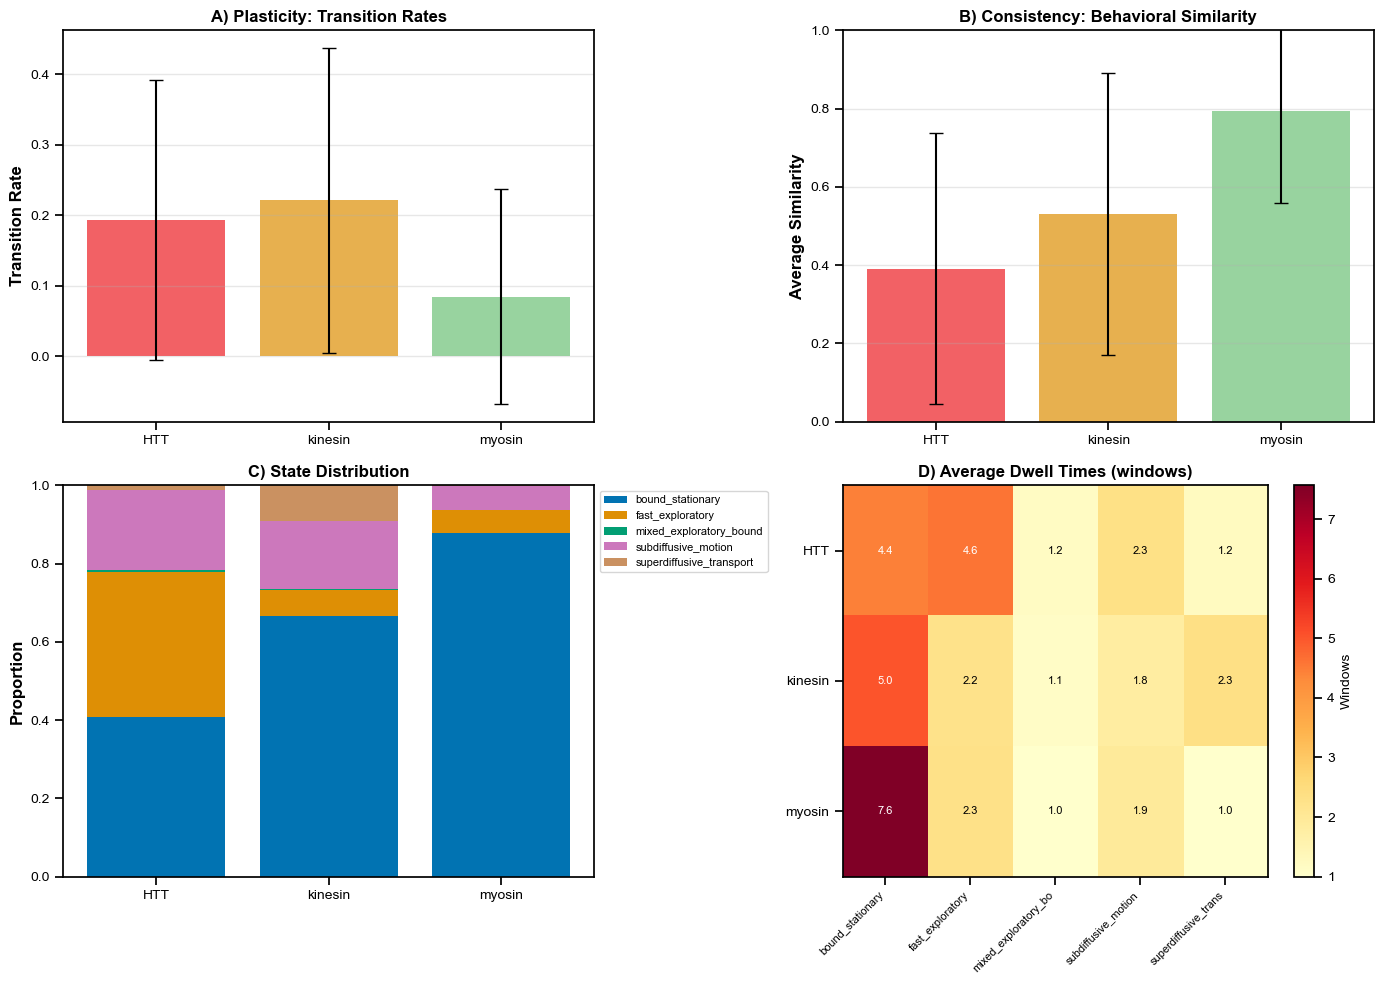

In [30]:
### Create comprehensive comparison figure

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Transition Rates
ax = axes[0, 0]
mol_names = list(transition_rate_data.keys())
means = [transition_rate_data[mol]['mean_rate'] for mol in mol_names]
stds = [transition_rate_data[mol]['std_rate'] for mol in mol_names]

colors_map = {'HTT': raiders_colors2[0], 'kinesin': raiders_colors2[1], 'myosin': raiders_colors2[2]}
colors = [colors_map.get(mol, 'gray') for mol in mol_names]

ax.bar(mol_names, means, yerr=stds, color=colors, alpha=0.7, capsize=5)
ax.set_ylabel('Transition Rate', fontsize=12, fontweight='bold')
ax.set_title('A) Plasticity: Transition Rates', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Similarity Scores (if available)
ax = axes[0, 1]
if len(similarity_results) > 0:
    sim_mol_names = list(similarity_results.keys())
    sim_means = [similarity_results[mol]['stats']['avg_similarity'] for mol in sim_mol_names]
    sim_stds = [similarity_results[mol]['stats']['std_similarity'] for mol in sim_mol_names]
    colors = [colors_map.get(mol, 'gray') for mol in sim_mol_names]
    
    ax.bar(sim_mol_names, sim_means, yerr=sim_stds, color=colors, alpha=0.7, capsize=5)
    ax.set_ylabel('Average Similarity', fontsize=12, fontweight='bold')
    ax.set_title('B) Consistency: Behavioral Similarity', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
else:
    ax.text(0.5, 0.5, 'Similarity analysis\nnot performed', 
           ha='center', va='center', fontsize=12)
    ax.set_title('B) Behavioral Similarity', fontsize=12, fontweight='bold')

# Plot 3: State Distribution
ax = axes[1, 0]

# Calculate state percentages for each molecule
state_pcts = {}
for mol in mols:
    if isinstance(segment_windowed_df, pl.DataFrame):
        mol_data = segment_windowed_df.filter(pl.col('mol') == mol)
        total = len(mol_data)
        state_counts = mol_data.group_by('final_population').agg(pl.len().alias('count'))
        state_pcts[mol] = {row['final_population']: row['count']/total for row in state_counts.to_dicts()}
    else:
        mol_data = segment_windowed_df[segment_windowed_df['mol'] == mol]
        total = len(mol_data)
        state_counts = mol_data['final_population'].value_counts()
        state_pcts[mol] = {state: count/total for state, count in state_counts.items()}

# Plot stacked bars
all_states = sorted(set().union(*[set(pcts.keys()) for pcts in state_pcts.values()]))
x_pos = np.arange(len(mols))
bottom = np.zeros(len(mols))

for i, state in enumerate(all_states):
    heights = [state_pcts[mol].get(state, 0) for mol in mols]
    ax.bar(x_pos, heights, bottom=bottom, label=state, color=colorblind_colors[i % len(colorblind_colors)])
    bottom += heights

ax.set_xticks(x_pos)
ax.set_xticklabels(mols)
ax.set_ylabel('Proportion', fontsize=12, fontweight='bold')
ax.set_title('C) State Distribution', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
ax.set_ylim(0, 1)

# Plot 4: Average Dwell Times by State
ax = axes[1, 1]

# Prepare data for heatmap
states_for_heatmap = sorted(dwell_comp_df['State'].unique())
dwell_matrix = np.zeros((len(mols), len(states_for_heatmap)))

for i, mol in enumerate(mols):
    for j, state in enumerate(states_for_heatmap):
        mol_state_data = dwell_comp_df[(dwell_comp_df['Molecule'] == mol) & 
                                       (dwell_comp_df['State'] == state)]
        if len(mol_state_data) > 0:
            dwell_matrix[i, j] = mol_state_data['Mean_Dwell_Windows'].values[0]

im = ax.imshow(dwell_matrix, aspect='auto', cmap='YlOrRd')
ax.set_xticks(range(len(states_for_heatmap)))
ax.set_xticklabels([s[:20] for s in states_for_heatmap], rotation=45, ha='right', fontsize=8)
ax.set_yticks(range(len(mols)))
ax.set_yticklabels(mols)
ax.set_title('D) Average Dwell Times (windows)', fontsize=12, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Windows', fontsize=10)

# Add values to heatmap
for i in range(len(mols)):
    for j in range(len(states_for_heatmap)):
        if dwell_matrix[i, j] > 0:
            text = ax.text(j, i, f'{dwell_matrix[i, j]:.1f}',
                          ha="center", va="center", color="white" if dwell_matrix[i, j] > dwell_matrix.max()/2 else "black",
                          fontsize=8)

plt.tight_layout()

if saved_dir:
    save_path = os.path.join(saved_dir, f'comprehensive_comparison_seg{SEGMENT_LENGTH}.svg')
    plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    print(f"\n✅ Saved comprehensive comparison to: {save_path}")

plt.show()

In [31]:
### Export all results to CSV files

print("\n" + "="*80)
print("EXPORTING RESULTS")
print("="*80)

# 1. Transition rate summary
transition_rate_summary = pd.DataFrame([
    {
        'Molecule': mol,
        'N_Segments': data['n_segments'],
        'Mean_Transition_Rate': data['mean_rate'],
        'Median_Transition_Rate': data['median_rate'],
        'Std_Transition_Rate': data['std_rate']
    }
    for mol, data in transition_rate_data.items()
])

# 2. Persistence summary
persistence_summary = persistence_df.copy()

# 3. Dwell time summary
dwell_summary = dwell_comp_df.copy()

# 4. Similarity summary (if available)
if len(similarity_results) > 0:
    similarity_summary = pd.DataFrame([
        {
            'Molecule': mol,
            'N_Segments': result['stats']['n_tracks'],
            'Avg_Similarity': result['stats']['avg_similarity'],
            'Std_Similarity': result['stats']['std_similarity'],
            'Min_Similarity': result['stats']['min_similarity'],
            'Max_Similarity': result['stats']['max_similarity']
        }
        for mol, result in similarity_results.items()
    ])
else:
    similarity_summary = None

# 5. Pairwise statistical tests
pairwise_summary = pd.DataFrame(pairwise_results)

# Save all summaries
output_dir = saved_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

transition_rate_summary.to_csv(os.path.join(output_dir, 'transition_rates_summary.csv'), index=False)
persistence_summary.to_csv(os.path.join(output_dir, 'state_persistence_summary.csv'), index=False)
dwell_summary.to_csv(os.path.join(output_dir, 'dwell_times_summary.csv'), index=False)
pairwise_summary.to_csv(os.path.join(output_dir, 'pairwise_comparisons.csv'), index=False)

if similarity_summary is not None:
    similarity_summary.to_csv(os.path.join(output_dir, 'similarity_summary.csv'), index=False)

print(f"\n✅ Exported results to: {output_dir}")
print("   Files created:")
print("   - transition_rates_summary.csv")
print("   - state_persistence_summary.csv")
print("   - dwell_times_summary.csv")
print("   - pairwise_comparisons.csv")
if similarity_summary is not None:
    print("   - similarity_summary.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\nYou now have comprehensive statistical analysis of molecular behavior")
print(f"based on fixed-length segments ({SEGMENT_LENGTH} windows each).")
print(f"\nKey findings can be used to:")
print(f"  1. Characterize HTT behavior relative to kinesin and myosin")
print(f"  2. Identify which states are most/least plastic")
print(f"  3. Quantify behavioral stereotypy")
print(f"  4. Support biological interpretation with statistical evidence")


EXPORTING RESULTS

✅ Exported results to: F:/plots/plasticity/
   Files created:
   - transition_rates_summary.csv
   - state_persistence_summary.csv
   - dwell_times_summary.csv
   - pairwise_comparisons.csv
   - similarity_summary.csv

ANALYSIS COMPLETE!

You now have comprehensive statistical analysis of molecular behavior
based on fixed-length segments (10 windows each).

Key findings can be used to:
  1. Characterize HTT behavior relative to kinesin and myosin
  2. Identify which states are most/least plastic
  3. Quantify behavioral stereotypy
  4. Support biological interpretation with statistical evidence


### 2. Filter Tracks by Minimum Windows

Based on the histogram above, choose a minimum number of windows that ensures comparable track lengths across molecules. This creates a standard time period for analysis.


In [ ]:
# Choose minimum windows based on your data (adjust as needed)
MIN_WINDOWS = 10  # Adjust based on histogram results

# Filter tracks
windowed_df_filtered, instant_df_filtered, filter_report = spt.filter_tracks_by_min_windows(
    windowed_df_classified_noungated,
    instant_df_classified_noungated,
    min_windows=MIN_WINDOWS
)

print(f"\n💡 Using tracks with at least {MIN_WINDOWS} time windows for transition analysis")


KeyError: 'unique_id'

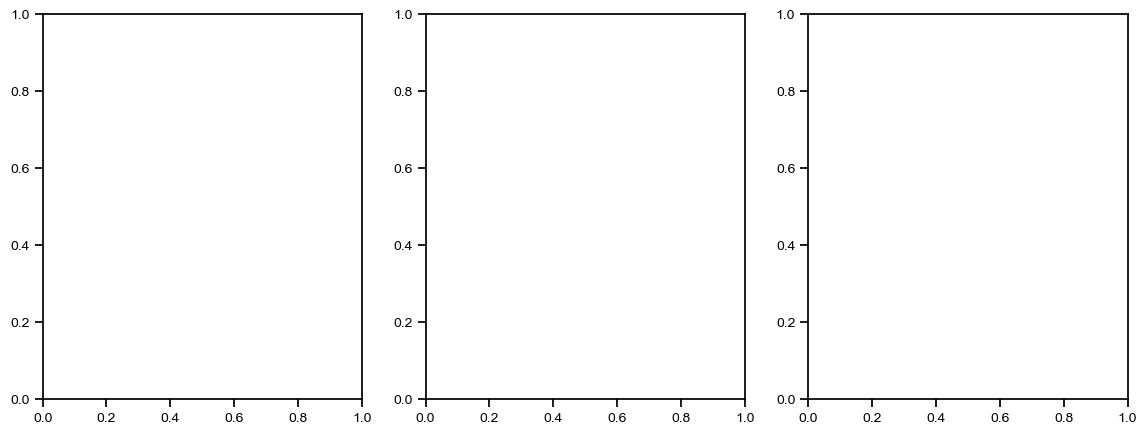

In [ ]:
# Re-plot histogram with filtered data to confirm
fig, axes, stats_filtered = spt.plot_windows_per_track_histogram(
    windowed_df_filtered,
    group_by='mol',
    save_path=saved_dir ,
    figsize=(14, 5),
    color_palette=raiders_colors2,
    transparent_background=True,
    max_windows=30,
    export_format='svg'
)


### 3. State Transition Analysis

Analyze which states transition to which other states, and how often. This reveals the plasticity of molecular states.


In [ ]:
# Analyze state transitions for each molecule separately
transition_results = spt.analyze_state_transitions(
    windowed_df_filtered,
    state_col='final_population',
    unique_id_col='unique_id',
    time_col='time_window',
    group_by='mol',  # Separate analysis by molecule
    normalize=True,  # Get transition probabilities
    min_windows=MIN_WINDOWS
)

# Print summary for each molecule
print("\n" + "="*80)
print("STATE TRANSITION SUMMARY BY MOLECULE")
print("="*80)

for mol, result in transition_results.items():
    print(f"\n{'─'*80}")
    print(f"MOLECULE: {mol}")
    print(f"{'─'*80}")
    stats = result['stats']
    print(f"Tracks analyzed: {stats['n_tracks']:,}")
    print(f"Total transitions: {stats['n_transitions']:,}")
    print(f"Avg transitions per track: {stats['avg_transitions_per_track']:.2f}")
    print(f"\nStates observed: {', '.join(stats['states'])}")
    
    print("\n🔄 Most common transitions:")
    top_transitions = result['transitions_summary'].head(10)
    for idx, row in top_transitions.iterrows():
        arrow = "→" if not row['is_self_transition'] else "↻"
        print(f"  {row['from_state']} {arrow} {row['to_state']}: "
              f"{row['count']:,} transitions ({row['probability']:.1%})")
    
    print("\n📌 State persistence (probability of staying in same state):")
    for state, persistence in sorted(stats['state_persistence'].items(), 
                                    key=lambda x: x[1], reverse=True):
        print(f"  {state}: {persistence:.1%}")


### 4. Visualize Transition Matrices

Create heatmaps showing transition probabilities between states for each molecule.


In [ ]:
# Plot transition matrices for each molecule
for mol, result in transition_results.items():
    print(f"\nPlotting transition matrix for {mol}...")
    
    # Plot probabilities
    fig, ax = spt.plot_transition_matrix(
        result,
        figsize=(10, 8),
        cmap='YlOrRd',
        save_path=saved_dir,
        export_format='svg',
        show_counts=False  # Show probabilities
    )
    plt.show()
    
    # Also plot counts
    fig, ax = spt.plot_transition_matrix(
        result,
        figsize=(10, 8),
        cmap='Blues',
        save_path=saved_dir,
        export_format='svg',
        show_counts=True  # Show counts
    )
    plt.show()


### 5. Count State Transitions per Track

Count how many transitions each track undergoes. This reveals track-level plasticity.


In [ ]:
# Count transitions per track
transition_counts_df = spt.count_state_transitions_per_track(
    windowed_df_filtered,
    state_col='final_population',
    unique_id_col='unique_id',
    time_col='time_window',
    additional_cols=['mol', 'type', 'geno', 'group']
)

# Display summary statistics
print("\n" + "="*80)
print("TRANSITION COUNTS PER TRACK - SUMMARY")
print("="*80)

if isinstance(transition_counts_df, pl.DataFrame):
    summary = transition_counts_df.group_by('mol').agg([
        pl.col('n_transitions').mean().alias('mean_transitions'),
        pl.col('n_transitions').median().alias('median_transitions'),
        pl.col('n_transitions').std().alias('std_transitions'),
        pl.col('transition_rate').mean().alias('mean_transition_rate'),
        pl.col('n_unique_states').mean().alias('mean_unique_states'),
        pl.len().alias('n_tracks')
    ]).sort('mol')
    print(summary)
else:
    summary = transition_counts_df.groupby('mol').agg({
        'n_transitions': ['mean', 'median', 'std'],
        'transition_rate': 'mean',
        'n_unique_states': 'mean',
        'unique_id': 'count'
    }).round(2)
    print(summary)


In [ ]:
# Visualize transition counts comparison
fig, ax = spt.plot_transition_counts_comparison(
    transition_counts_df,
    x='mol',
    hue='n_unique_states',
    y='n_transitions',
    figsize=(10, 6),
    palette='Set2',
    save_path=saved_dir,
    export_format='svg'
)
plt.show()

# Also plot transition rate
fig, ax = spt.plot_transition_counts_comparison(
    transition_counts_df,
    x='mol',
    hue='n_unique_states',
    y='transition_rate',
    figsize=(10, 6),
    palette='Set2',
    save_path=saved_dir,
    export_format='svg'
)
plt.show()


### 6. State Dwell Time Analysis

Analyze how long tracks remain in each state before transitioning.


In [ ]:
# Analyze dwell times for each molecule
# First, determine your time window duration (in seconds)
# This should match your windowing parameters from feature extraction
WINDOW_DURATION_SECONDS = 6.0  # Adjust based on your window size and frame rate

dwell_results = spt.analyze_state_dwell_times(
    windowed_df_filtered,
    state_col='final_population',
    unique_id_col='unique_id',
    time_col='time_window',
    window_duration=WINDOW_DURATION_SECONDS,
    group_by='mol'
)

# Print summary for each molecule
print("\n" + "="*80)
print("STATE DWELL TIME ANALYSIS")
print("="*80)

for mol, result in dwell_results.items():
    print(f"\n{'─'*80}")
    print(f"MOLECULE: {mol}")
    print(f"{'─'*80}")
    
    summary_stats = result['summary_stats']
    if len(summary_stats) > 0:
        print("\nDwell time statistics (windows):")
        print(summary_stats[['state', 'n_visits', 'n_tracks', 'mean_dwell', 
                            'median_dwell', 'std_dwell']].to_string(index=False))
        
        if 'mean_duration_s' in summary_stats.columns:
            print("\nDwell time statistics (seconds):")
            print(summary_stats[['state', 'mean_duration_s', 'median_duration_s', 
                                'std_duration_s']].to_string(index=False))
    else:
        print("No dwell time data available")


In [ ]:
# COCKNOSE

### Choose Your Approach

Now pick which approach to use for similarity analysis:

- **Variable-Length** (`sequence_df_variable`): Uses all data, good for overall patterns
- **Fixed-Length** (`sequence_df_fixed`): Fair comparison, good for quantitative plasticity metrics

For the cells below, we'll demonstrate **both approaches**. You can use either or both depending on your needs.


In [10]:
# Visualize dwell time distributions for each molecule
for mol, result in dwell_results.items():
    print(f"\nPlotting dwell time distributions for {mol}...")
    
    fig, ax = spt.plot_dwell_time_distributions(
        result,
        figsize=(12, 6),
        color_palette=colorblind_colors,
        save_path=saved_dir,
        export_format='svg',
        bins=range(1, 20)  # Adjust bin range as needed
    )
    if fig:
        plt.show()


NameError: name 'dwell_results' is not defined

In [13]:
### Similarity Analysis - APPROACH B: Fixed-Length Segments
mols = ['HTT', 'kinesin','myosin']

SAMPLE_SIZE_PER_MOL = 10

# Calculate similarity for fixed-length segments
similarity_results_fixed = {}

for mol in mols:
    print(f"\n{'='*80}")
    print(f"Calculating similarity for {mol} (Fixed-Length Segments)")
    print(f"{'='*80}")
    
    # Filter to this molecule
    if isinstance(sequence_df_fixed, pl.DataFrame):
        mol_segments = sequence_df_fixed.filter(pl.col('mol') == mol)
    else:
        mol_segments = sequence_df_fixed[sequence_df_fixed['mol'] == mol]
    
    # Calculate similarity
    try:
        similarity_result = spt.calculate_track_similarity(
            mol_segments,
            sequence_col='state_sequence',
            unique_id_col='segment_id',  # Note: using segment_id
            method='damerau_levenshtein',
            normalize=True,
            sample_size=min(SAMPLE_SIZE_PER_MOL, len(mol_segments)),
            random_seed=42
        )
        
        similarity_results_fixed[mol] = similarity_result
        
        print(f"\n📊 Statistics for {mol}:")
        print(f"  Segments compared: {similarity_result['stats']['n_tracks']}")
        print(f"  Average similarity: {similarity_result['stats']['avg_similarity']:.3f}")
        print(f"  Similarity range: {similarity_result['stats']['min_similarity']:.3f} - {similarity_result['stats']['max_similarity']:.3f}")
        
    except Exception as e:
        print(f"⚠️  Error calculating similarity for {mol}: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "="*80)
print("💡 COMPARISON OF APPROACHES:")
print("="*80)
print("\nVariable-Length vs Fixed-Length Similarity:")
for mol in mols:
    if mol in similarity_results_variable and mol in similarity_results_fixed:
        var_sim = similarity_results_variable[mol]['stats']['avg_similarity']
        fix_sim = similarity_results_fixed[mol]['stats']['avg_similarity']
        print(f"{mol:10s}: Variable={var_sim:.3f}, Fixed={fix_sim:.3f}, Diff={abs(var_sim-fix_sim):.3f}")
print("="*80)



Calculating similarity for HTT (Fixed-Length Segments)
Sampled 10 tracks for similarity calculation
⚠️  Warning: Track eeh2h_30_10125_R1_seg1 sequence is not a list, skipping
⚠️  Warning: Track eeh2h_eeh2x_12_736_R1_R1_seg1 sequence is not a list, skipping
⚠️  Warning: Track eeh2h_eeh2x_1_2618_R1_R1_seg3 sequence is not a list, skipping
⚠️  Warning: Track eeh2h_eeh2x_3_8448_R1_R1_seg1 sequence is not a list, skipping
⚠️  Warning: Track eeh2h_eeh2x_2_5186_R1_R1_seg3 sequence is not a list, skipping
⚠️  Warning: Track eeh2h_eeh2x_29_6263_R2_R2_seg6 sequence is not a list, skipping
⚠️  Warning: Track eeh2h_eeh2x_3_8406_R1_R1_seg1 sequence is not a list, skipping
⚠️  Warning: Track eeh2h_eeh2x_29_6217_R2_R2_seg3 sequence is not a list, skipping
⚠️  Warning: Track eeh2h_34_11173_R1_seg0 sequence is not a list, skipping
⚠️  Warning: Track eeh2h_eeh2x_30_6940_R2_R2_seg0 sequence is not a list, skipping
⚠️  Error calculating similarity for HTT: No valid sequences found. All sequences are None

Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Temp\ipykernel_71096\3556198338.py", line 22, in <module>
    similarity_result = spt.calculate_track_similarity(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\GITHUB_SOFTWARE\SPTnano\src\SPTnano\helper_scripts.py", line 6062, in calculate_track_similarity
    raise ValueError("No valid sequences found. All sequences are None, empty, or contain only None values.")
ValueError: No valid sequences found. All sequences are None, empty, or contain only None values.
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Temp\ipykernel_71096\3556198338.py", line 22, in <module>
    similarity_result = spt.calculate_track_similarity(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\GITHUB_SOFTWARE\SPTnano\src\SPTnano\helper_scripts.py", line 6062, in calculate_track_similarity
    raise ValueError("No valid sequences found. All sequences are None, empty, or contain only

NameError: name 'similarity_results_variable' is not defined

### 7. Track Similarity Analysis (Damerau-Levenshtein Distance)

Calculate pairwise similarity between track state sequences. This reveals whether different molecules have similar or distinct state transition patterns.

**Note:** This can be computationally intensive for large datasets. Consider sampling if you have many tracks.


In [ ]:
# First, create state sequence dataframe
sequence_df = spt.create_state_sequence_dataframe(
    windowed_df_filtered,
    state_col='final_population',
    unique_id_col='unique_id',
    time_col='time_window',
    additional_cols=['mol', 'type', 'geno', 'group']
)

print(f"\n✅ Created state sequences for {len(sequence_df):,} tracks")
print("\nExample sequences:")
if isinstance(sequence_df, pl.DataFrame):
    print(sequence_df.head(5))
else:
    print(sequence_df.head(5))


In [ ]:
sequence_df

In [ ]:
# IMPORTANT: Diagnose sequence data before running similarity analysis
# This will identify any issues with the sequences (None values, empty sequences, etc.)
diagnostics = spt.diagnose_state_sequences(
    sequence_df,
    sequence_col='state_sequence',
    unique_id_col='unique_id'
)

print(f"\n💡 If you see warnings above, the similarity calculation will automatically skip problematic tracks.")
print(f"   You can proceed with the next cell - it will work with the valid tracks only.")


In [ ]:
similarity_result = spt.calculate_track_similarity(
    mol_sequences,
    sample_size=100
)

In [ ]:
# Calculate track similarity for each molecule separately
# Sample tracks if you have too many (for computational efficiency)
SAMPLE_SIZE_PER_MOL = None #100  # Adjust based on computational resources

similarity_results = {}

mols = ['HTT', 'kinesin', 'myosin']

for mol in mols:
    print(f"\n{'='*80}")
    print(f"Calculating track similarity for {mol}")
    print(f"{'='*80}")
    
    # Filter to this molecule
    if isinstance(sequence_df, pl.DataFrame):
        mol_sequences = sequence_df.filter(pl.col('mol') == mol)
    else:
        mol_sequences = sequence_df[sequence_df['mol'] == mol]
    
    # Calculate similarity
    try:
        similarity_result = spt.calculate_track_similarity(
            mol_sequences,
            sequence_col='state_sequence',
            unique_id_col='unique_id',
            method='damerau_levenshtein',
            normalize=True,
            sample_size=min(SAMPLE_SIZE_PER_MOL, len(mol_sequences)),
            random_seed=42
        )
        
        similarity_results[mol] = similarity_result
        
        print(f"\n📊 Statistics for {mol}:")
        print(f"  Tracks compared: {similarity_result['stats']['n_tracks']}")
        print(f"  Average similarity: {similarity_result['stats']['avg_similarity']:.3f}")
        print(f"  Similarity range: {similarity_result['stats']['min_similarity']:.3f} - {similarity_result['stats']['max_similarity']:.3f}")
        
    except Exception as e:
        print(f"⚠️  Error calculating similarity for {mol}: {e}")
        print("   Make sure 'python-Levenshtein' and 'pyxdameraulevenshtein' are installed:")


In [ ]:
# Visualize similarity matrices as heatmaps
for mol, result in similarity_results.items():
    print(f"\nPlotting similarity matrix for {mol}...")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot similarity matrix
    im = ax.imshow(result['similarity_matrix'].values, cmap='viridis', aspect='auto')
    
    ax.set_title(f'Track Similarity Matrix - {mol}\n(Damerau-Levenshtein Distance)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Track Index', fontsize=12)
    ax.set_ylabel('Track Index', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Similarity', fontsize=12)
    
    # Save
    plt.tight_layout()
    if saved_dir:
        filename = f"similarity_matrix_{mol}.svg"
        full_path = os.path.join(saved_dir, filename)
        plt.savefig(full_path, dpi=300, bbox_inches='tight', transparent=True)
        print(f"✅ Saved to: {full_path}")
    
    plt.show()


### 8. Summary: Key Insights

Compare the transition patterns across molecules to understand their behavioral differences.


In [ ]:
# Create comprehensive summary table
print("\n" + "="*80)
print("COMPREHENSIVE TRANSITION ANALYSIS SUMMARY")
print("="*80)

summary_data = []

for mol in mols:
    if mol in transition_results:
        trans_stats = transition_results[mol]['stats']
        
        # Get transition counts summary
        if isinstance(transition_counts_df, pl.DataFrame):
            mol_trans_counts = transition_counts_df.filter(pl.col('mol') == mol)
            avg_transitions = mol_trans_counts['n_transitions'].mean()
            avg_rate = mol_trans_counts['transition_rate'].mean()
            avg_unique_states = mol_trans_counts['n_unique_states'].mean()
        else:
            mol_trans_counts = transition_counts_df[transition_counts_df['mol'] == mol]
            avg_transitions = mol_trans_counts['n_transitions'].mean()
            avg_rate = mol_trans_counts['transition_rate'].mean()
            avg_unique_states = mol_trans_counts['n_unique_states'].mean()
        
        # Get dwell time info
        if mol in dwell_results and len(dwell_results[mol]['summary_stats']) > 0:
            avg_dwell = dwell_results[mol]['summary_stats']['mean_dwell'].mean()
        else:
            avg_dwell = np.nan
        
        # Get similarity info
        if mol in similarity_results:
            avg_similarity = similarity_results[mol]['stats']['avg_similarity']
        else:
            avg_similarity = np.nan
        
        summary_data.append({
            'Molecule': mol,
            'N Tracks': trans_stats['n_tracks'],
            'Total Transitions': trans_stats['n_transitions'],
            'Avg Trans/Track': avg_transitions,
            'Transition Rate': avg_rate,
            'Avg Unique States': avg_unique_states,
            'Avg Dwell (windows)': avg_dwell,
            'Avg Track Similarity': avg_similarity
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("="*80)

# Save summary
if saved_dir:
    summary_path = os.path.join(saved_dir, 'transition_analysis_summary.csv')
    summary_df.to_csv(summary_path, index=False)
    print(f"\n✅ Saved summary to: {summary_path}")


### 9. Key Questions Answered

**Q1: Which state transitions are most common?**
- See transition matrices and "Most common transitions" output above
- Look for high-probability transitions in the heatmaps

**Q2: Which transitions DON'T happen?**
- Zero or near-zero probabilities in transition matrices indicate forbidden/rare transitions
- Check the transition_probabilities dataframes for zeros

**Q3: How often do transitions occur?**
- "Transition Rate" = average transitions per window
- "Avg Trans/Track" = total transitions per track
- Compare across molecules to see which are more/less plastic

**Q4: Track similarity - do molecules behave similarly?**
- Higher average similarity = more stereotyped behavior
- Lower similarity = more diverse/heterogeneous behavior
- Compare similarity scores across molecules

**Q5: State dwell times vs overall state percentages**
- Dwell time analysis shows *temporal persistence* (how long states last)
- Overall percentages show *prevalence* (how much of the time spent in each state)
- These are related but distinct:
  - A state can be common but brief (many short visits)
  - A state can be rare but persistent (few long visits)
  - Compare dwell_times['summary_stats'] with your stacked bar percentages to see the difference

**Key Insight:** 
- **Kinesin** should show high transport state persistence (long dwells, low transitions)
- **Myosin** should show high stationary state persistence
- **HTT** behavior relative to these controls reveals its functional character


### 📦 Dependencies for Track Similarity

If you get an import error when calculating track similarity, install these packages:

```bash
pip install python-Levenshtein pyxdameraulevenshtein
```

These provide efficient implementations of string distance metrics used for comparing state sequences.
